      time_s   HR_bpm
0  17720.148  71.7703
1  17721.023  68.5714
2  17721.859  71.7703
3  17722.789  64.5161
4  17723.703  65.6455


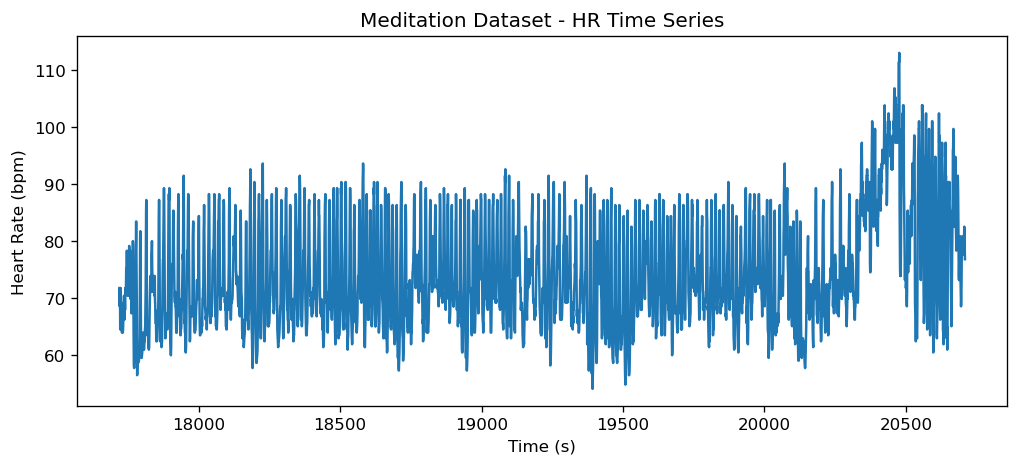

In [177]:
"""Download and process PhysioNet heart rate (HR) data for analysis."""
#PhysioNet HR data 
import sys
from pathlib import Path 
from io import StringIO 
from re import search
import requests
import pandas as pd 
import matplotlib.pyplot as plt

# Define data directory (relative to notebook)
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Define dataset filename and URL
filename = "C4.med"
file_path = DATA_DIR / filename
physionet_url = "https://physionet.org/content/meditation/1.0.0/data/chi/C4.med"  # example placeholder, do 1 file first 

# Download file if not available locally
if not file_path.exists():
    print(f"Downloading {filename} from PhysioNet...")
    try:
        response = requests.get(physionet_url, timeout=15)
        response.raise_for_status()
        file_path.write_bytes(response.content)
        text = response.text 
        print("Download complete.")
    except requests.RequestException as e:
        print(f"Failed to download dataset: {e}")
        sys.exit() 
else:
    text = file_path.read_text(encoding="utf-8")

# Extract <code> block
match = search(r"<code>([\s\S]*?)</code>", text)
if not match:
    raise ValueError("No <code> block found in file.")
data_str = match.group(1).strip()

df_med = pd.read_csv(
    StringIO(data_str), 
    sep=r"\s+", 
    header=None, 
    names=["time_s", "HR_bpm"],
    dtype={"time_s": float, "HR_bpm": float})

print(df_med.head())

# Plot HR over time
plt.figure(figsize=(10,4), dpi=120)
plt.plot(df_med["time_s"], df_med["HR_bpm"])
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (bpm)")
plt.title("Meditation Dataset - HR Time Series")
plt.show()





FILE:  data\chi\C1.med
beat_times sz 4034


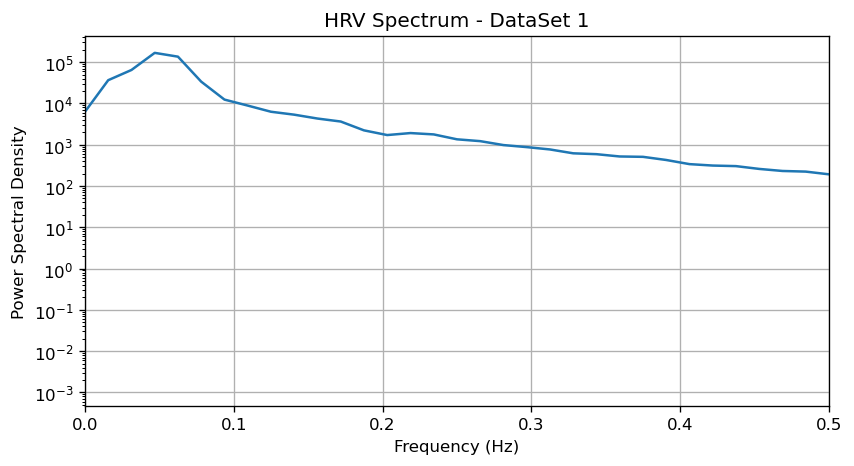

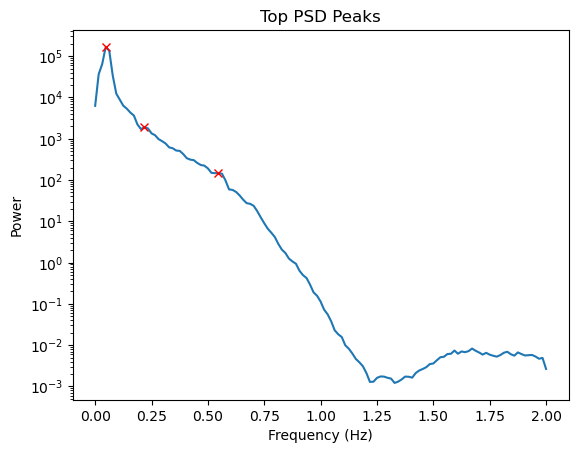



special0-1 : 0.3364722366212129
special1-2:  0.1941560144409574


FILE:  data\chi\C2.med
beat_times sz 4332


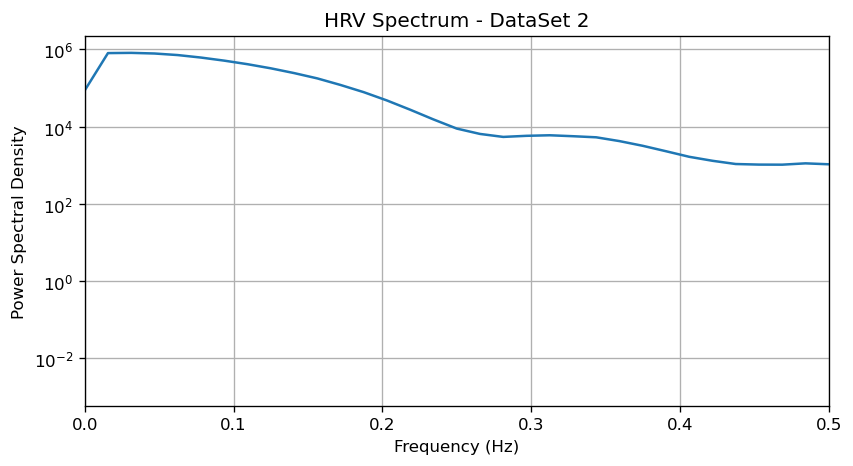

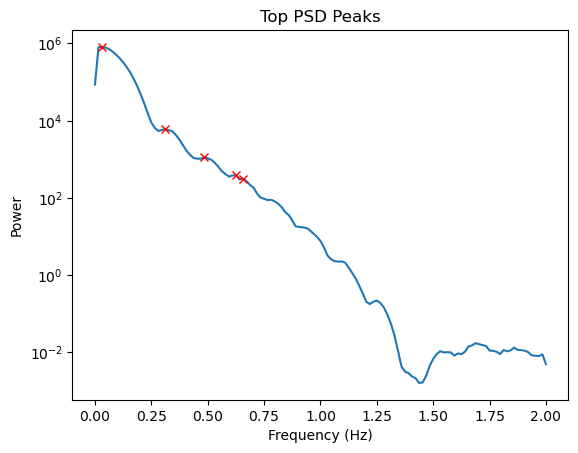



special0-1 : 0.6690496289808848
special1-2:  0.5738004229273791


FILE:  data\chi\C3.med
beat_times sz 3767


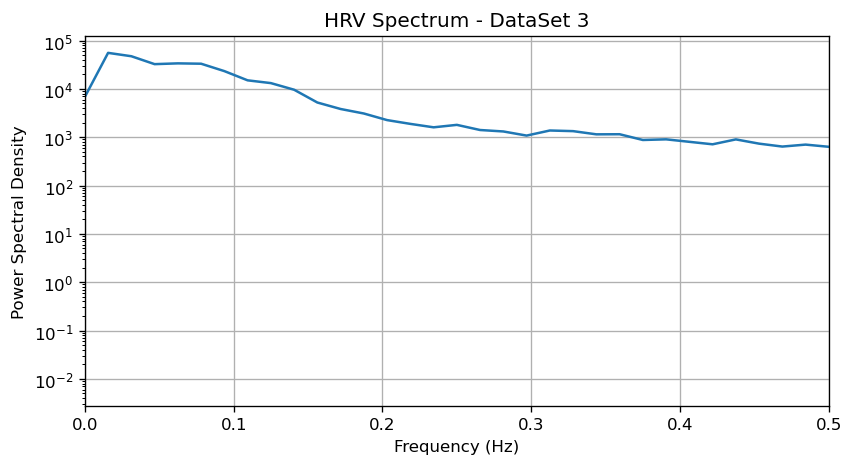

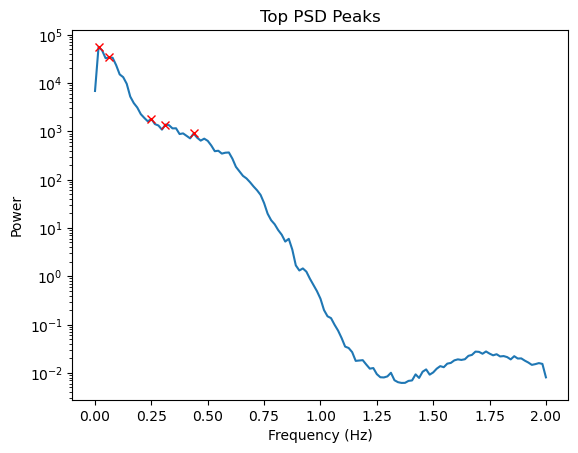



special0-1 : 0.4519851237430572
special1-2:  0.5877866649021191


FILE:  data\chi\C4.med
beat_times sz 3699


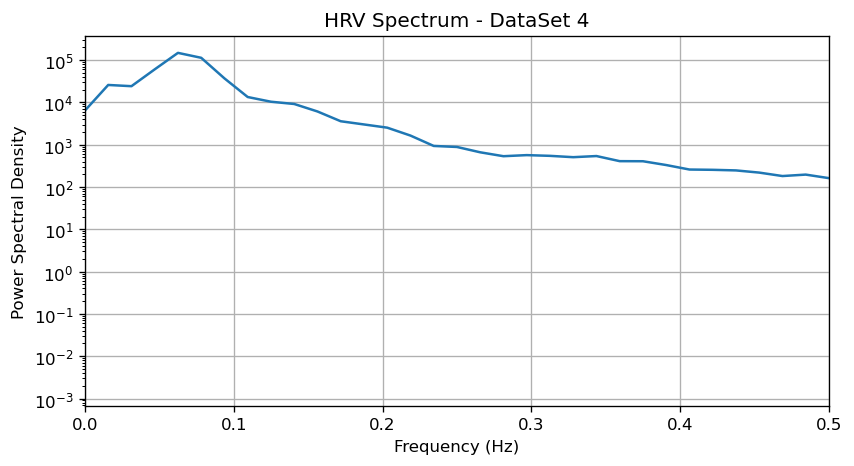

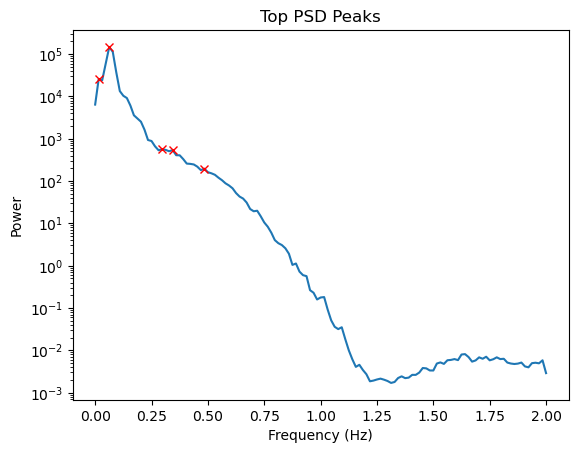



special0-1 : 0.5363047090669756
special1-2:  0.6225296133459919


FILE:  data\chi\C5.med
beat_times sz 3874


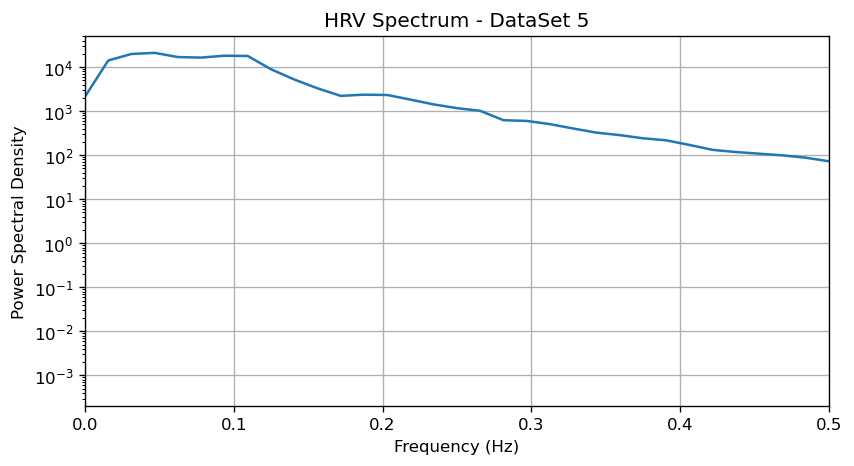

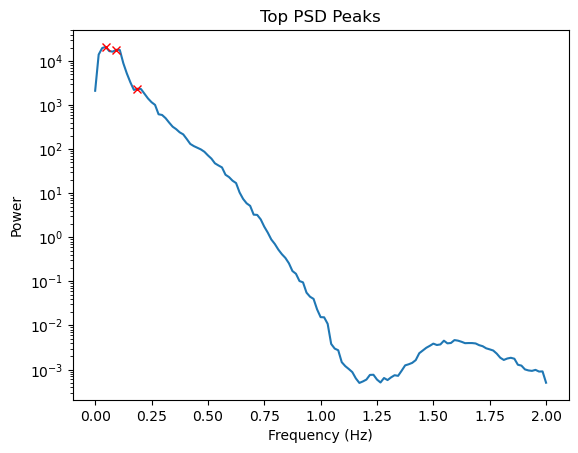



special0-1 : 0.4054651081081644
special1-2:  0.4054651081081644


FILE:  data\chi\C6.med
beat_times sz 3984


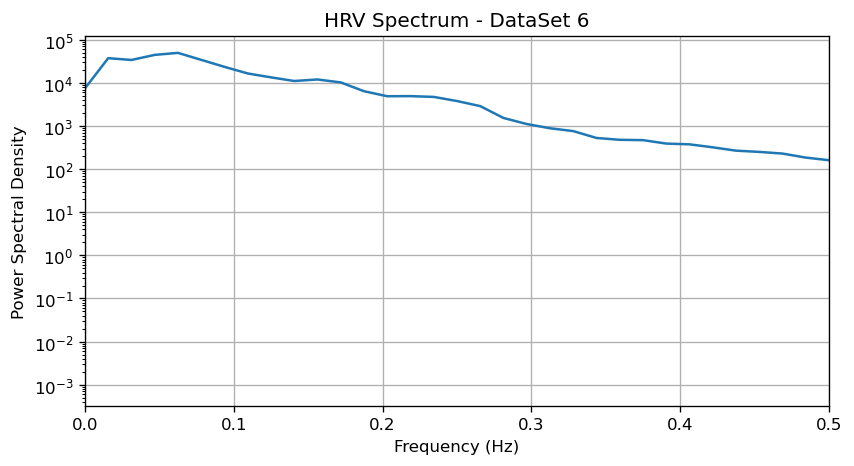

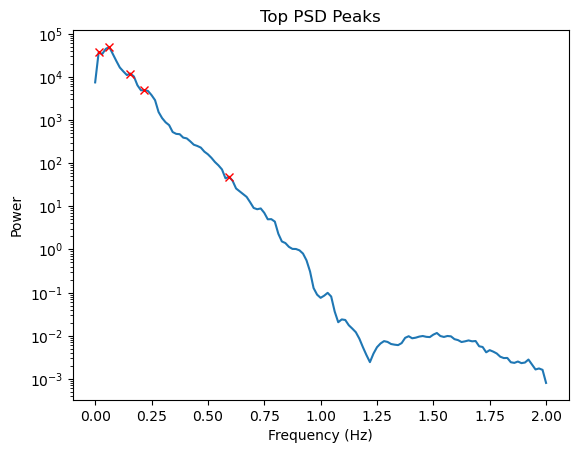



special0-1 : 0.3136575588550416
special1-2:  0.5389965007326869


FILE:  data\chi\C7.med
beat_times sz 6465


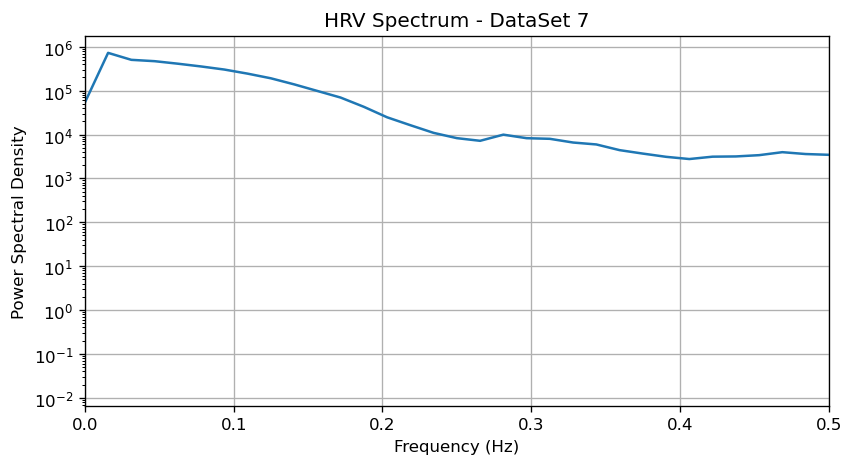

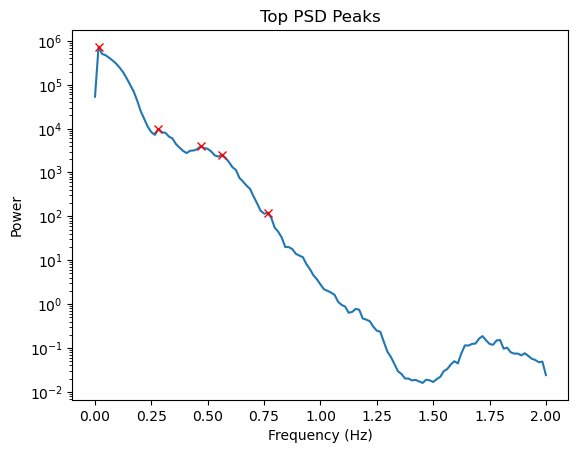



special0-1 : 0.5508309583796898
special1-2:  0.6061358035703155


FILE:  data\chi\C8.med
beat_times sz 5090


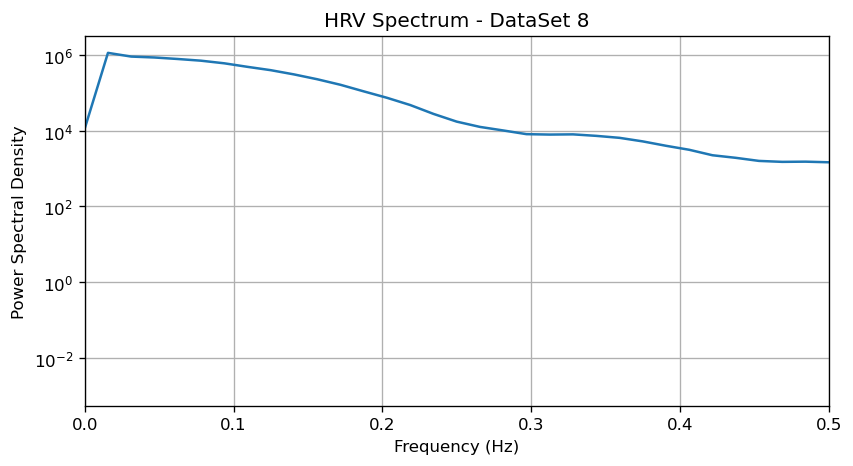

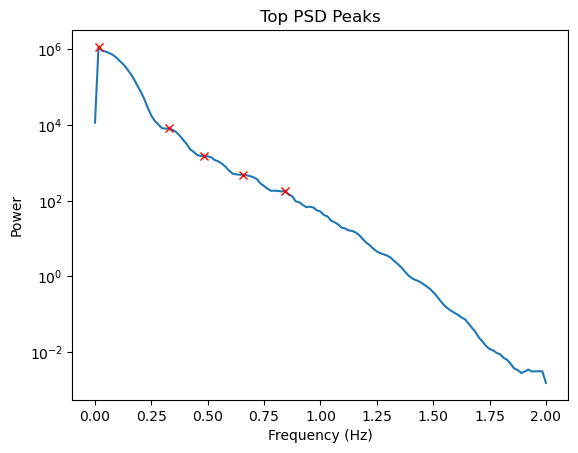



special0-1 : 0.5753641449035618
special1-2:  0.45366720992604215


In [187]:
"""Download and process one PhysioNet heart rate (HR) data set for analysis."""
import math
from scipy.signal import welch
from scipy import interpolate
from scipy.signal import find_peaks

physionet_url = "https://physionet.org/content/meditation/1.0.0/data/" 

def get_lines(filename):  
    file_path = DATA_DIR / filename 
    # Download file if not present locally 
    if not file_path.exists():
        print(f"\n\nDownloading {filename} from PhysioNet...") 
        try: 
            response = requests.get(physionet_url+filename, timeout=15) 
            response.raise_for_status() 
            file_path.write_bytes(response.content) 
            text = response.text 
            print("Download complete.")
        except requests.RequestException as e: 
            print(f"Failed to download dataset: {e}") 
            sys.exit("didn't already have file and unable to download from listed url") 
    # already have local file 
    else: 
        text = file_path.read_text(encoding="utf-8")
    print('\n\nFILE: ', file_path)
    # Extract <code> block
    match = search(r"<code>([\s\S]*?)</code>", text)
    if not match:
        raise ValueError("No <code> block found in file.")
    data_str = match.group(1).strip()
    return data_str

#make sub-dir for this set 
SUB_DIR = Path("data/chi")
SUB_DIR.mkdir(exist_ok=True)

for i in range(8): 
    j = i + 1  
    med_file = "chi/C" + str(j) + ".med" 
    ds = get_lines(med_file)

    df_med = pd.read_csv(
        StringIO(ds), 
        sep='\\s+', 
        header=None,names=["time_s","HR_bpm"],
        dtype={"time_s": float, "HR_bpm": float})

    beat_times = df_med['time_s']
    print('beat_times sz',len(beat_times))

    # Compute RR intervals (in seconds)
    rr_intervals_sec = np.diff(beat_times)
    # Convert to milliseconds
    rr_intervals_ms = rr_intervals_sec * 1000
    # Create cumulative time series from RR intervals
    rr_times = beat_times[1:]  # timestamps aligned with rr_intervals
    fs = 4.0  # desired interpolation rate in Hz (commonly 4 Hz for HRV)

    # Create interpolation function
    interp_func = interpolate.interp1d(
        rr_times, 
        rr_intervals_ms, 
        kind='cubic', 
        fill_value='extrapolate')
    # Evenly spaced time grid
    t_even = np.arange(rr_times.iloc[0], rr_times.iloc[-1], 1/fs)
    rr_interp = interp_func(t_even)

    # Apply FFT (or Welch) to get power spectral density
    f, Pxx = welch(rr_interp, fs=fs, nperseg=256)

    #print ('len f',len(f))
    # Plot the power spectral density
    plt.figure(figsize=(8,4), dpi=120)
    plt.semilogy(f, Pxx)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('HRV Spectrum - DataSet '+str(i+1))
    plt.xlim(0, 0.5)  # HRV bands are usually below 0.5 Hz
    plt.grid(True)
    plt.show()
    plt.close()
    #print('f.min and max: ', f.min(), f.max())

    # Find all peaks
    peaks, properties = find_peaks(Pxx, height=None, prominence=0.1) #0.001  
    # 'prominence' helps filter out noise; tune threshold based on data
    # Sort by peak height (descending)
    peak_heights = properties['prominences'] if 'prominences' in properties else Pxx[peaks]
    top_n = 5  # number of peaks to extract
    top_indices = peaks[np.argsort(peak_heights)[-top_n:]]  # top N peaks by height

    # Corresponding frequencies and PSD values
    top_freqs = f[top_indices]
    top_powers = Pxx[top_indices]

    #print("Top frequencies:", top_freqs)
    #print("Top powers:", top_powers)

    plt.semilogy(f, Pxx)
    plt.plot(top_freqs, top_powers, "rx")  # red x marks the top peaks
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('Top PSD Peaks')
    plt.show()
    plt.close()
    #print('f.min and max: ',f.min(), f.max())

    #special ratio         
    num = top_freqs[0] + top_freqs[1]
    denom = max(top_freqs[0], top_freqs[1])
    special = math.log(num / denom)
    print("\n\nspecial 0-1 :", special)
    num = top_freqs[1] + top_freqs[2]
    denom = max(top_freqs[1], top_freqs[2])
    special = math.log(num / denom)
    print("special 1-2: ", special)

    #add pre for comparison
    #other data sets ..




FILE:  data\chi\C1.pre


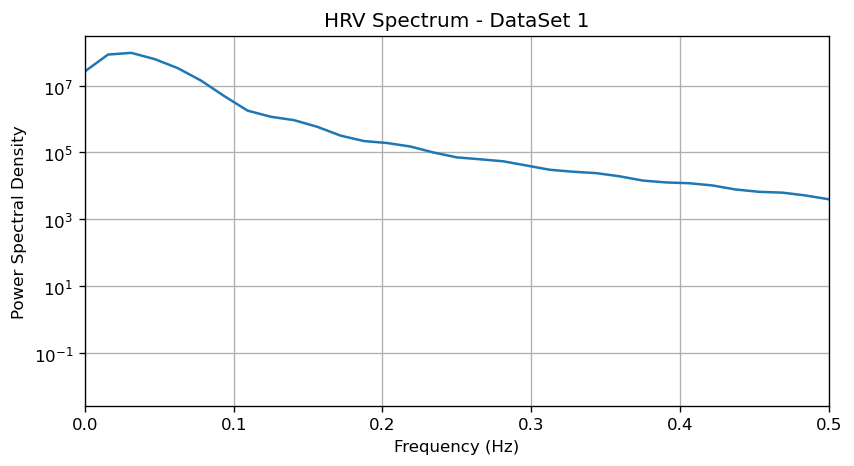

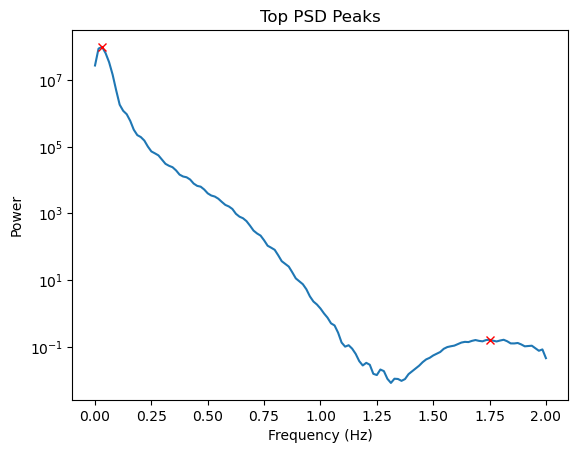



GR 0..1 : 0.017699577099400857


FILE:  data\chi\C2.pre


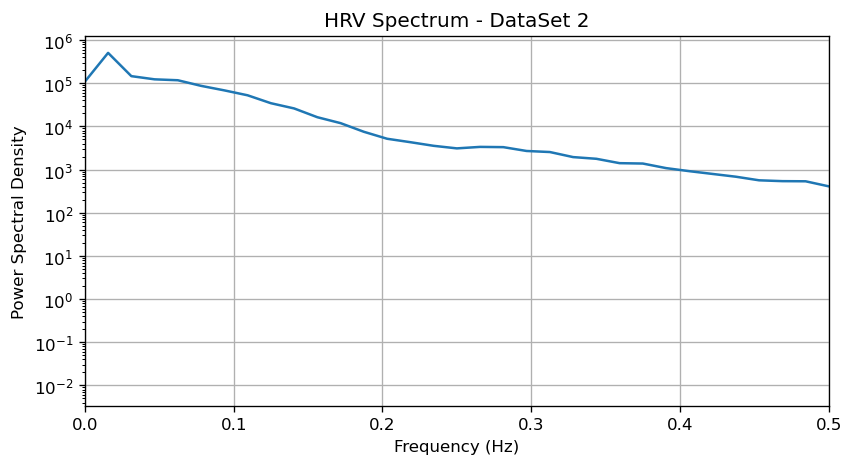

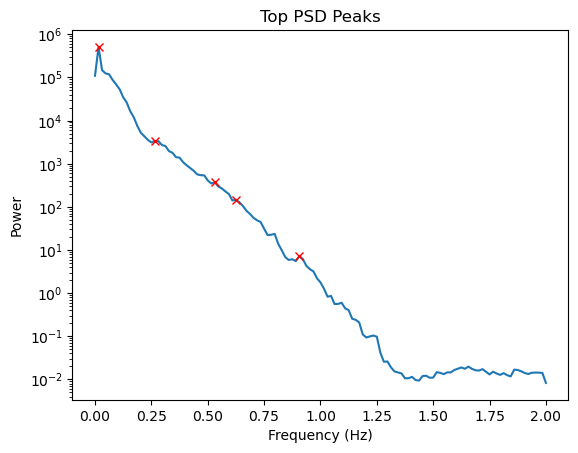



GR 0..1 : 0.5245244681241527
GR 1..2:  0.6151856390902335


FILE:  data\chi\C3.pre


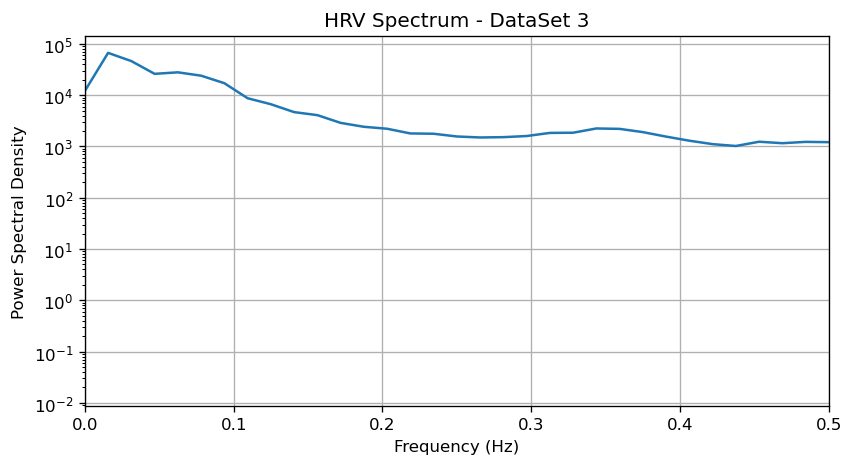

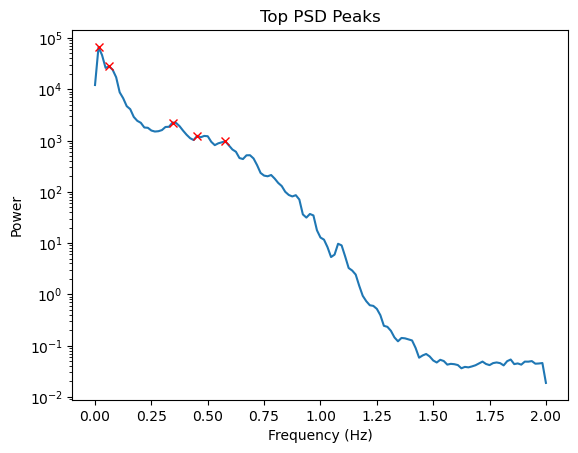



GR 0..1 : 0.5787368293822011
GR 1..2:  0.5645298027378517


FILE:  data\chi\C4.pre


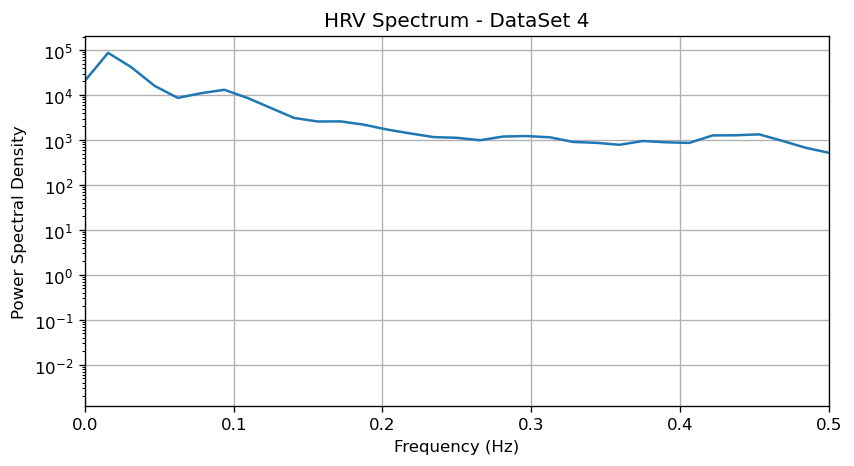

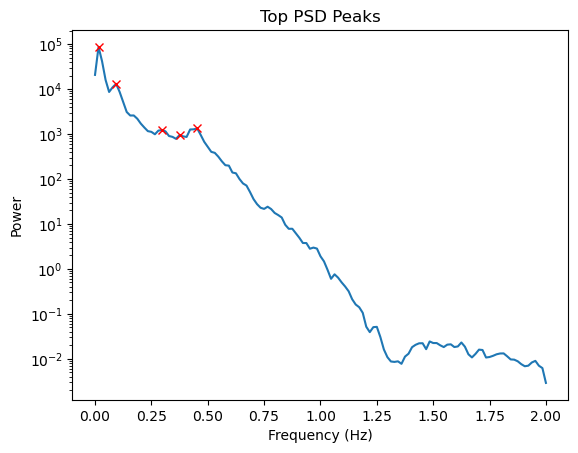



GR 0..1 : 0.5831462853456169
GR 1..2:  0.5039051809214169


FILE:  data\chi\C5.pre


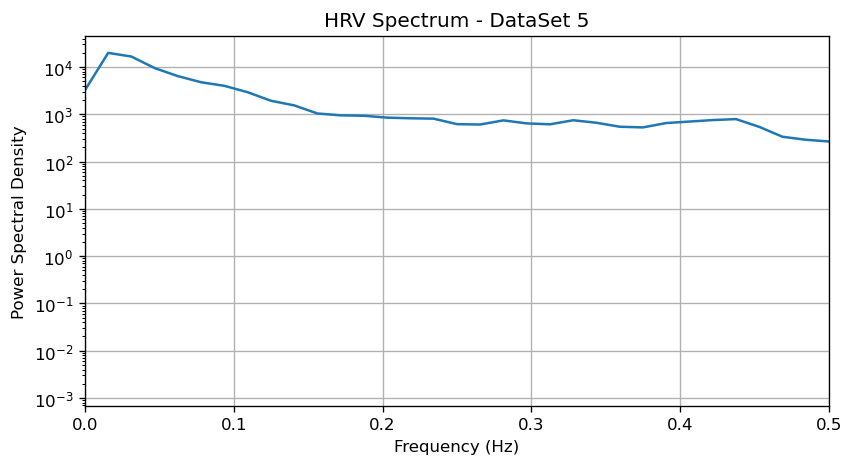

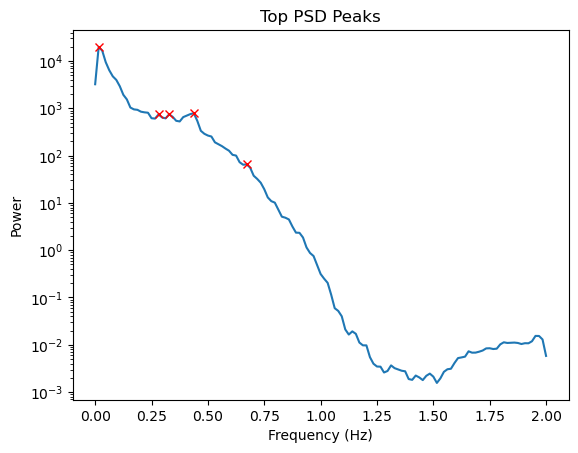



GR 0..1 : 0.34967374847974886
GR 1..2:  0.6190392084062235


FILE:  data\chi\C6.pre


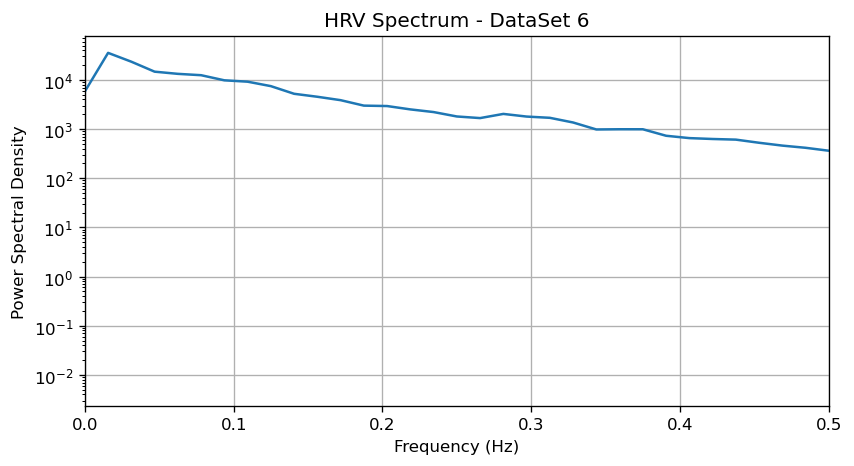

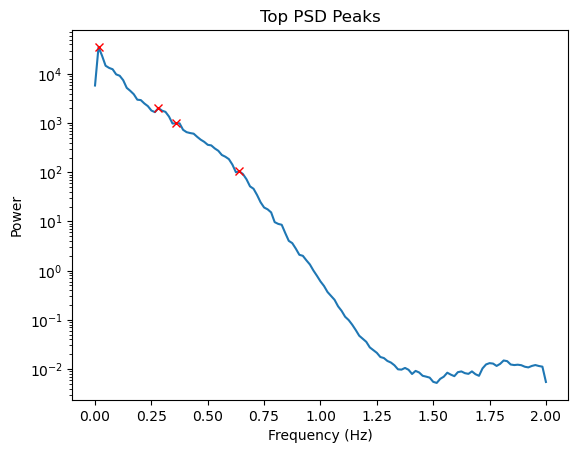



GR 0..1 : 0.4453110166553641
GR 1..2:  0.578077850775158


FILE:  data\chi\C7.pre


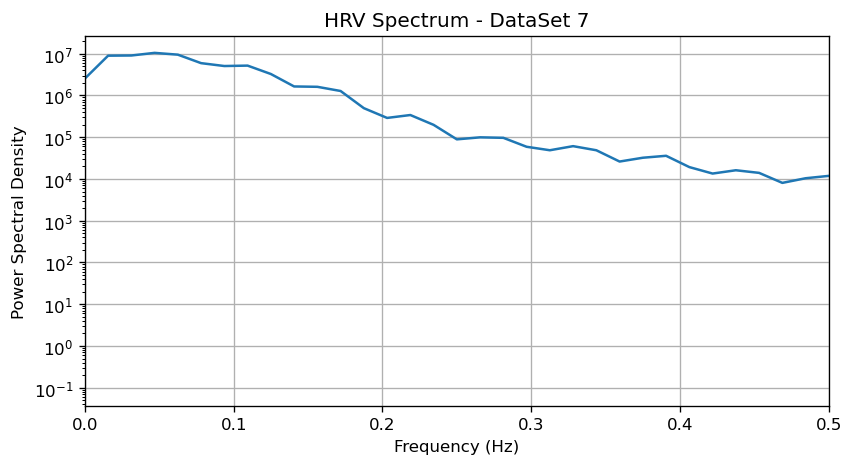

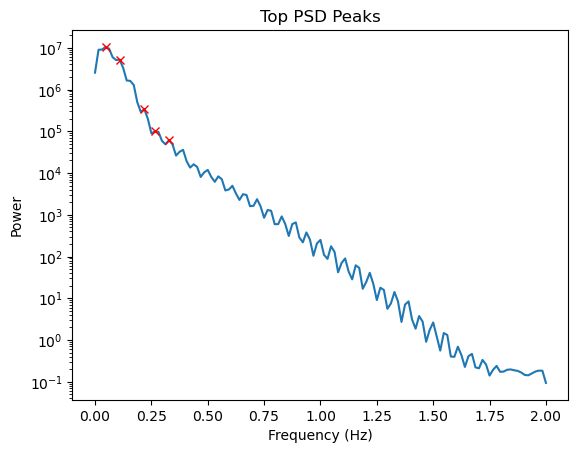



GR 0..1 : 0.5930637220029628
GR 1..2:  0.5108256237659907


FILE:  data\chi\C8.pre


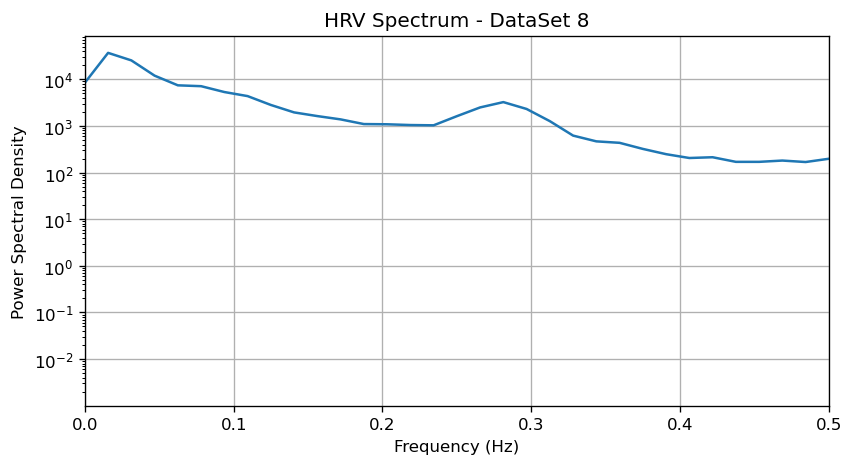

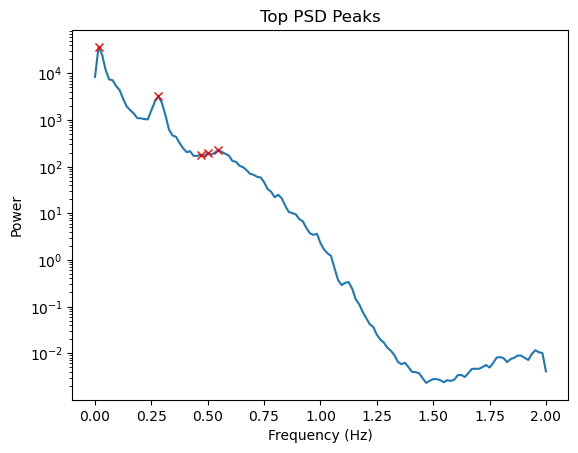



GR 0..1 : 0.661398482245365
GR 1..2:  0.6493445579015524


FILE:  data\chi\C1.med


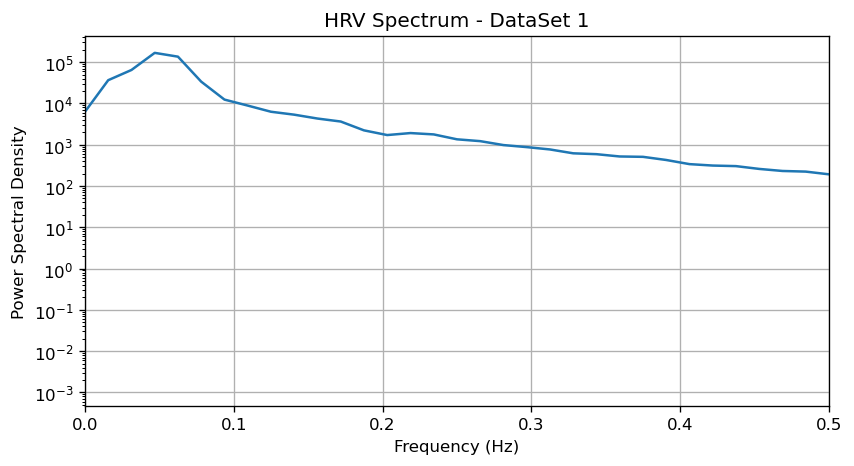

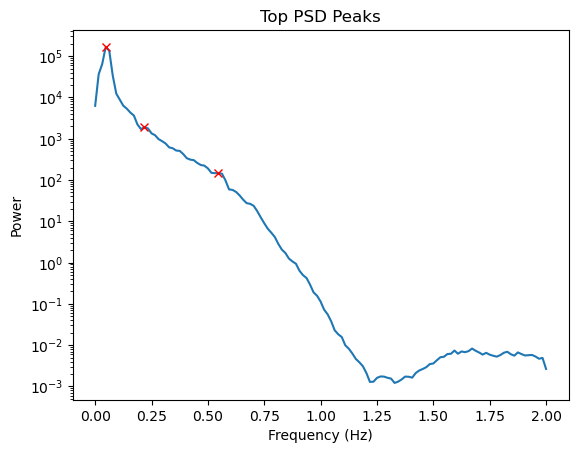



GR 0..1 : 0.3364722366212129
GR 1..2:  0.1941560144409574


FILE:  data\chi\C2.med


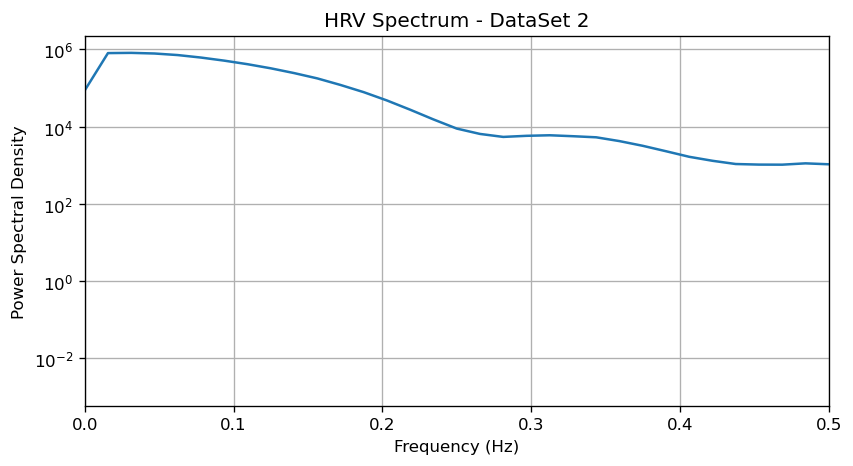

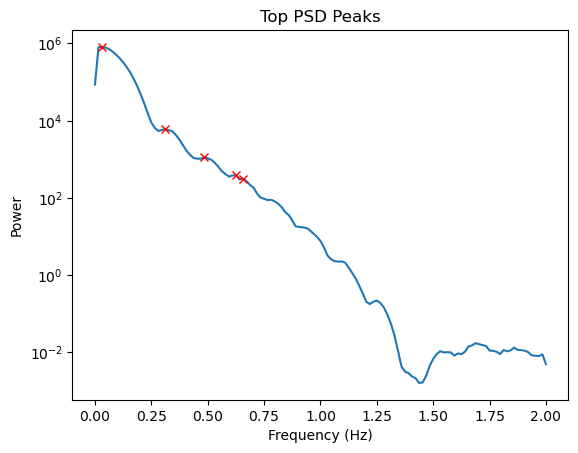



GR 0..1 : 0.6690496289808848
GR 1..2:  0.5738004229273791


FILE:  data\chi\C3.med


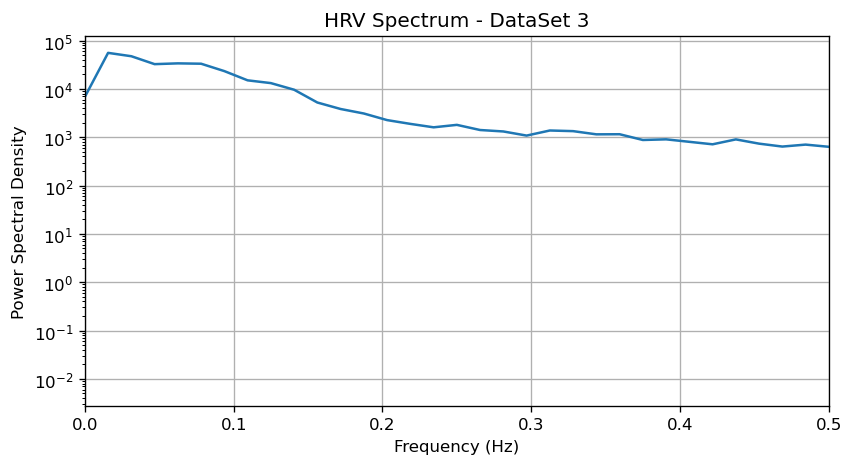

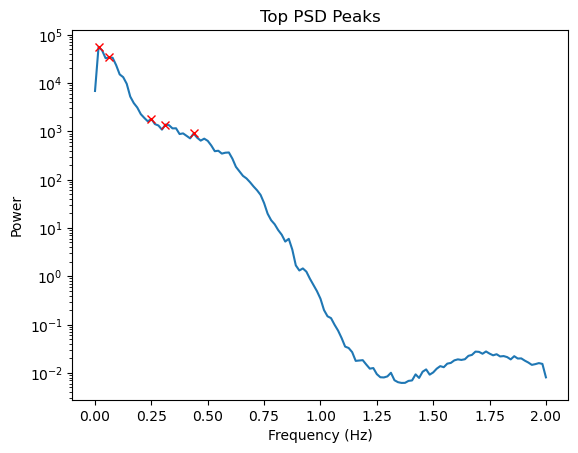



GR 0..1 : 0.4519851237430572
GR 1..2:  0.5877866649021191


FILE:  data\chi\C4.med


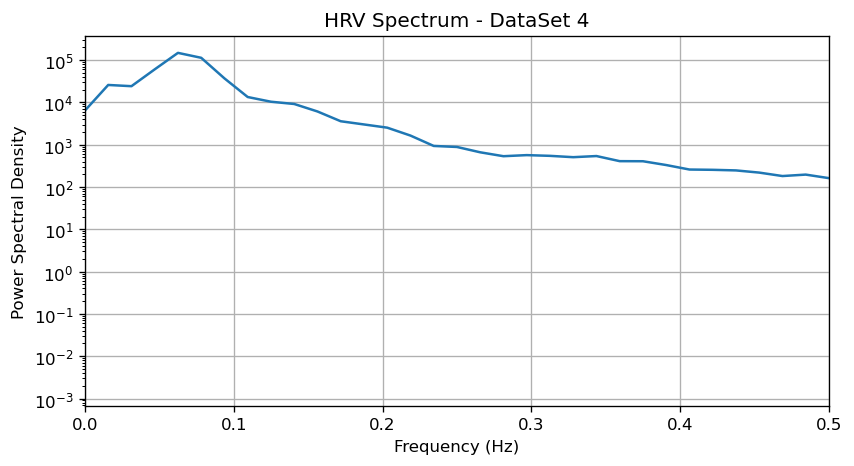

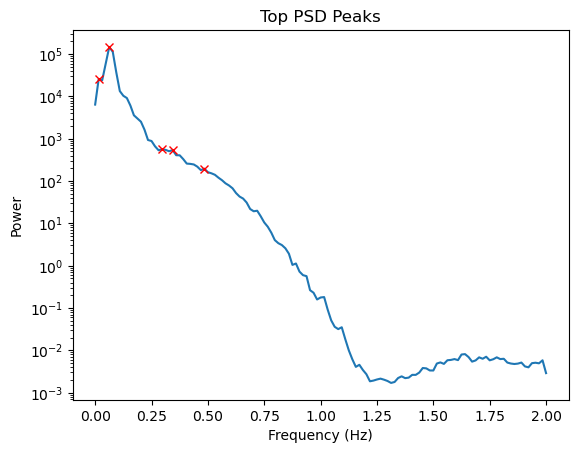



GR 0..1 : 0.5363047090669756
GR 1..2:  0.6225296133459919


FILE:  data\chi\C5.med


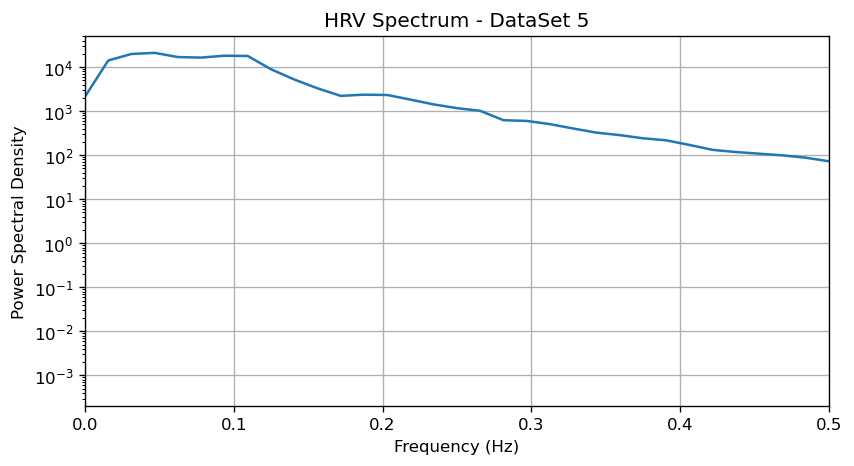

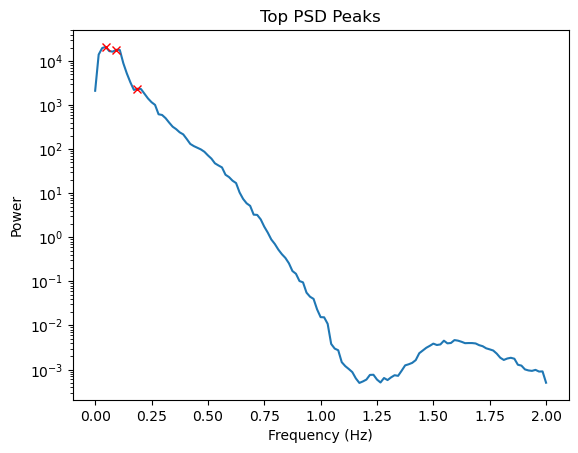



GR 0..1 : 0.4054651081081644
GR 1..2:  0.4054651081081644


FILE:  data\chi\C6.med


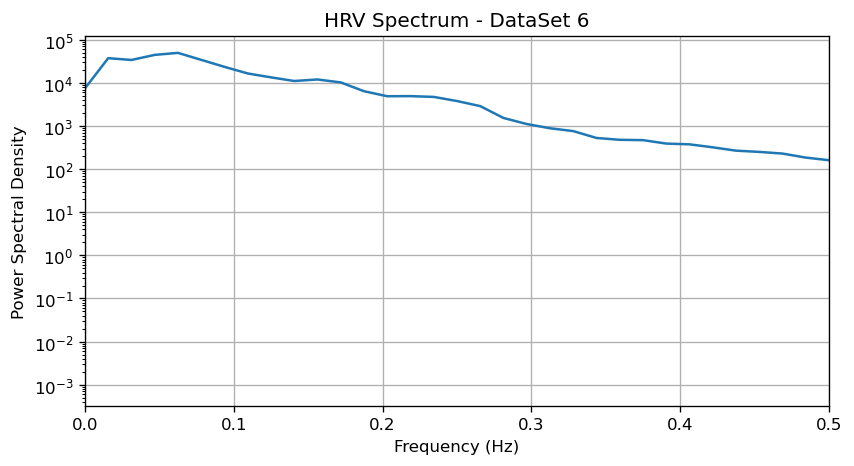

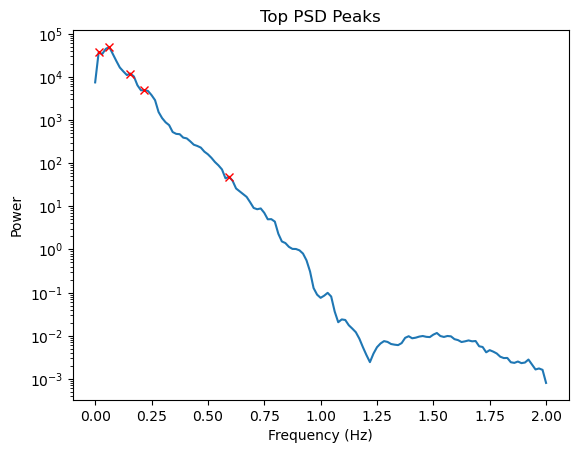



GR 0..1 : 0.3136575588550416
GR 1..2:  0.5389965007326869


FILE:  data\chi\C7.med


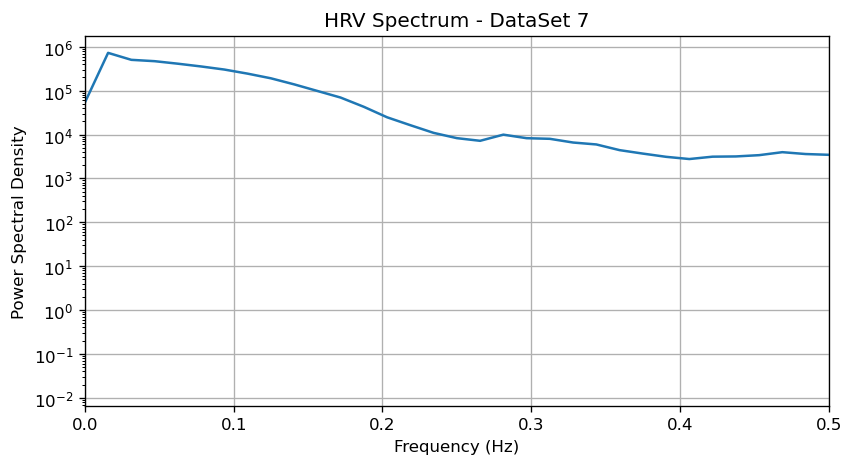

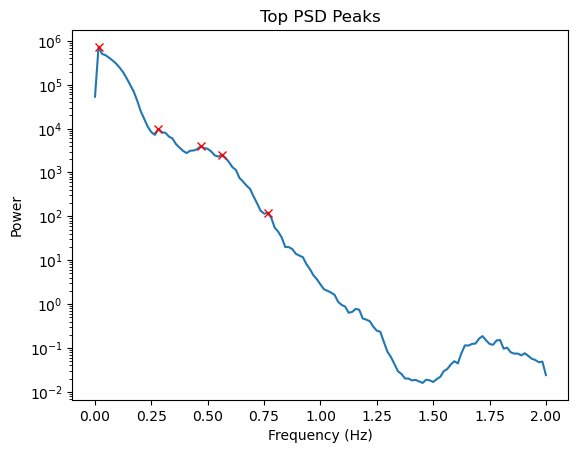



GR 0..1 : 0.5508309583796898
GR 1..2:  0.6061358035703155


FILE:  data\chi\C8.med


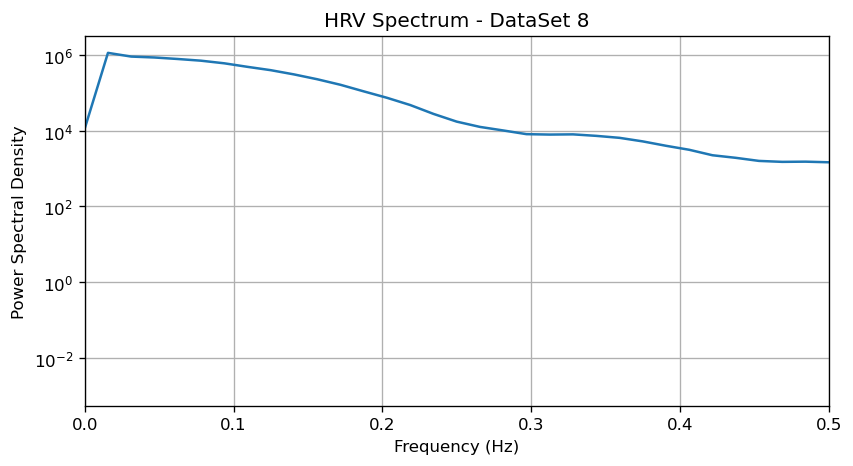

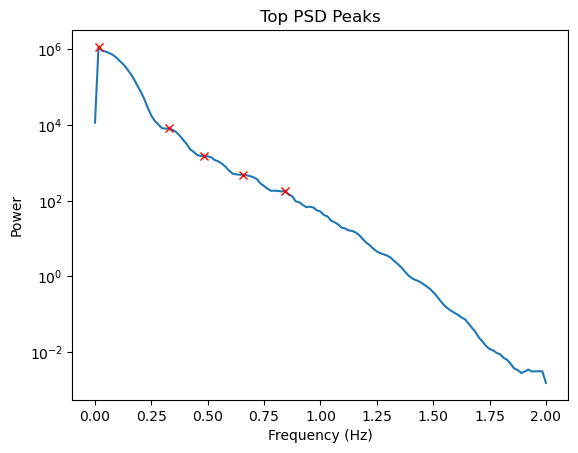



GR 0..1 : 0.5753641449035618
GR 1..2:  0.45366720992604215


FILE:  data\ironman\I1


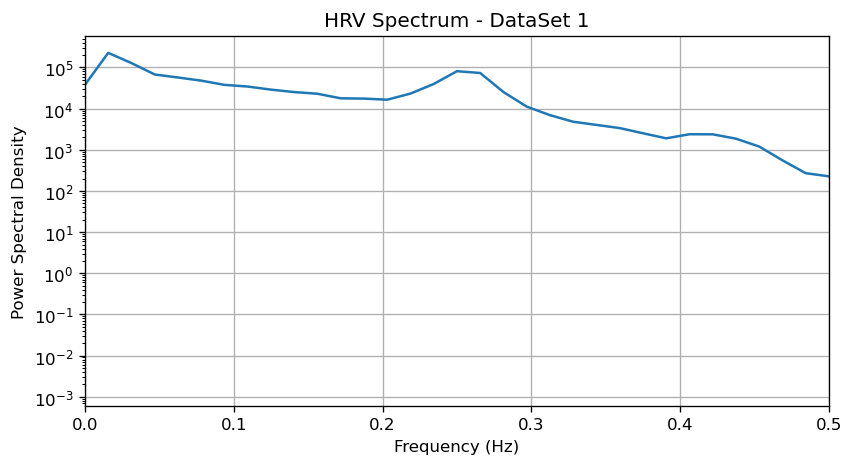

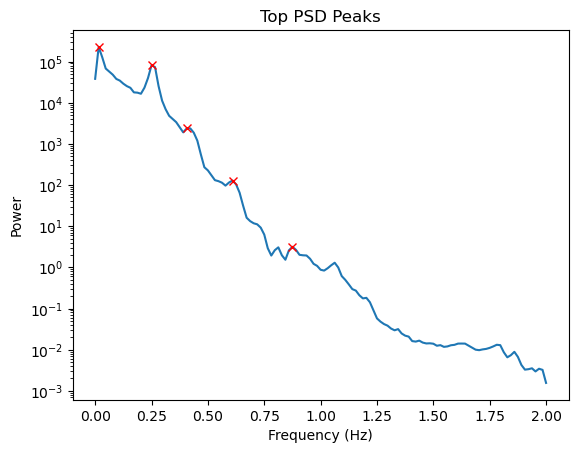



GR 0..1 : 0.5285252008653916
GR 1..2:  0.5108256237659907


FILE:  data\ironman\I2


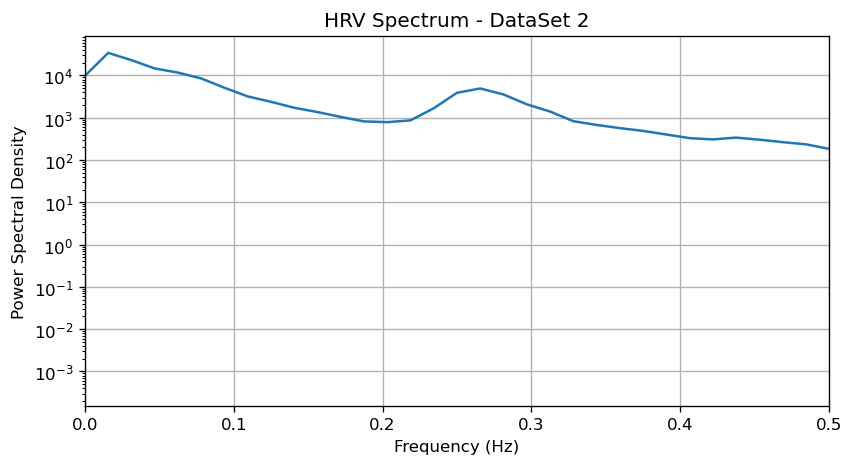

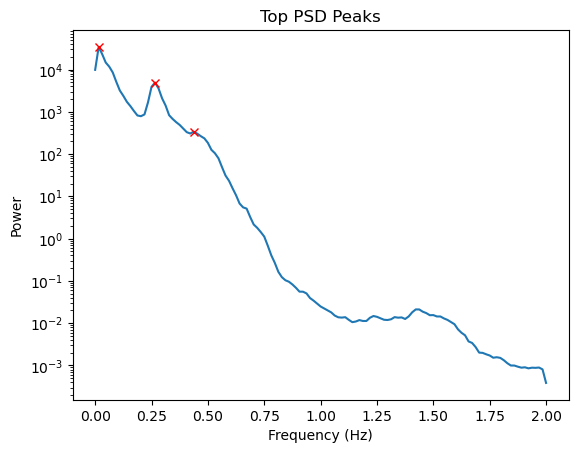



GR 0..1 : 0.4744579795951159
GR 1..2:  0.05715841383994862


FILE:  data\ironman\I3


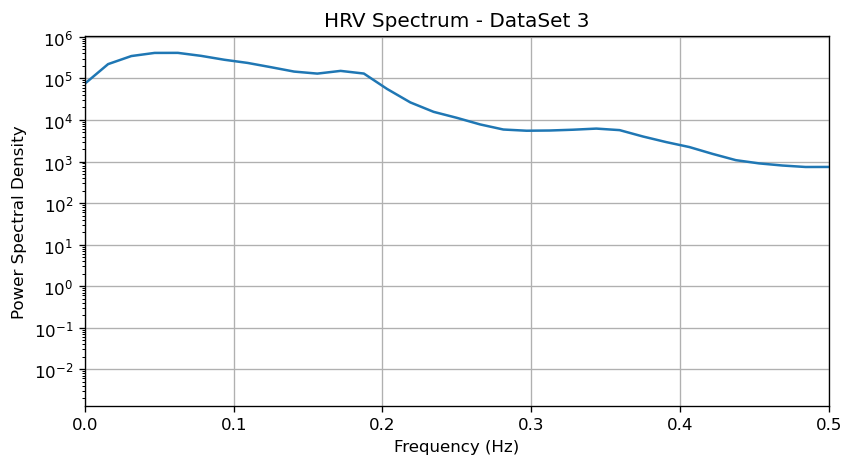

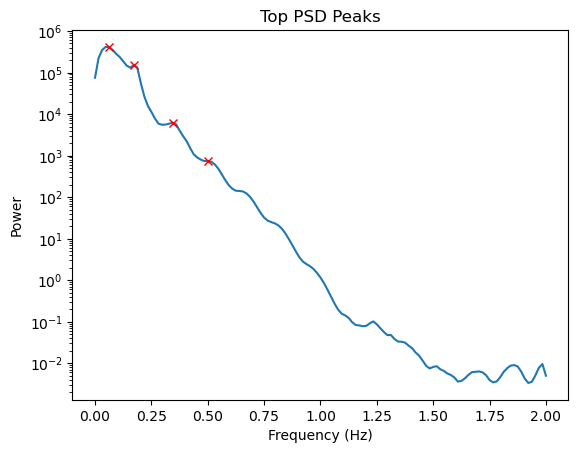



GR 0..1 : 0.5232481437645479
GR 1..2:  0.4054651081081644


FILE:  data\ironman\I4


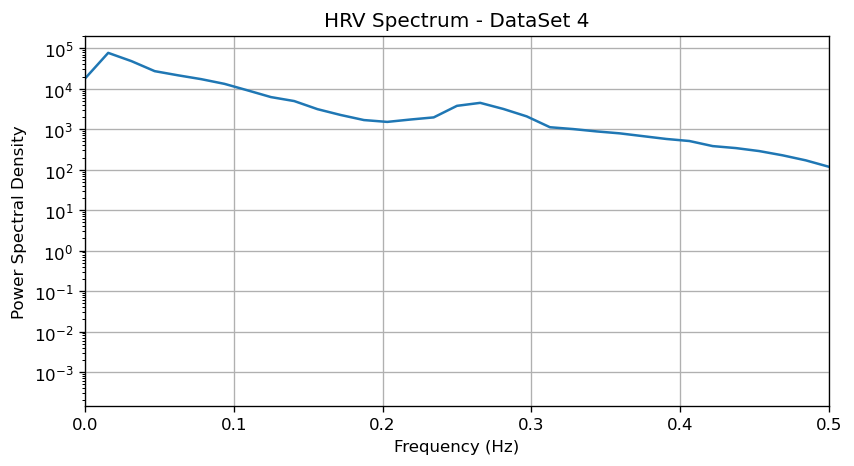

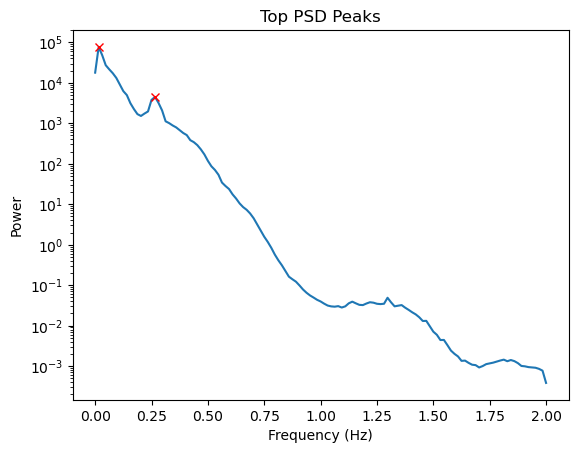



GR 0..1 : 0.05715841383994862


FILE:  data\ironman\I5


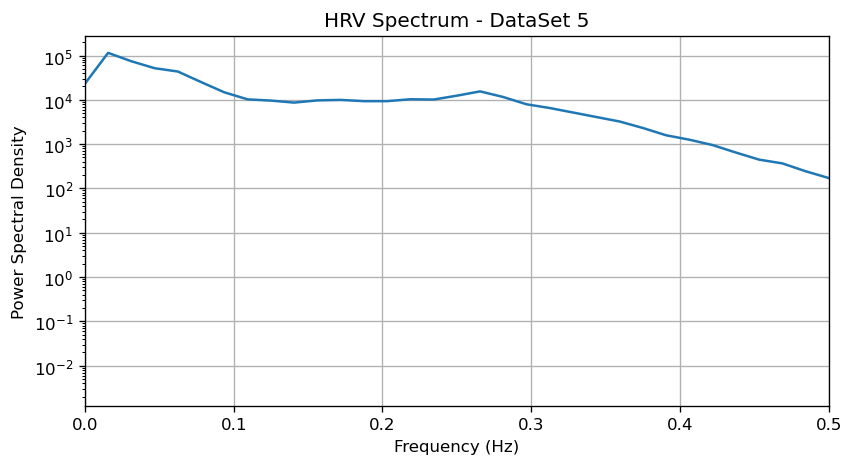

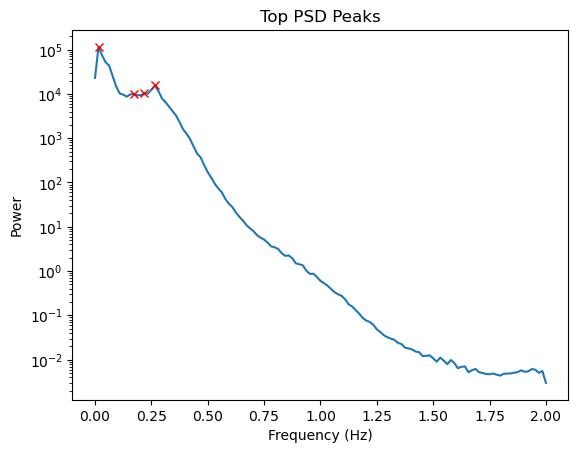



GR 0..1 : 0.5798184952529422
GR 1..2:  0.4989911661189878


FILE:  data\ironman\I6


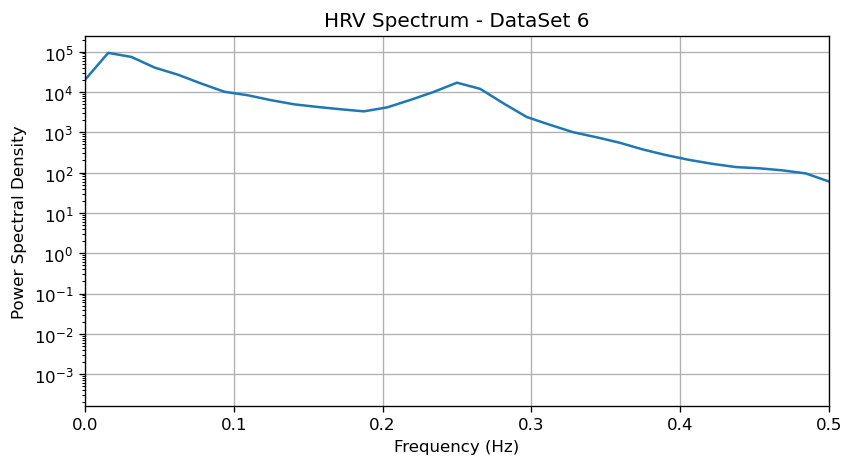

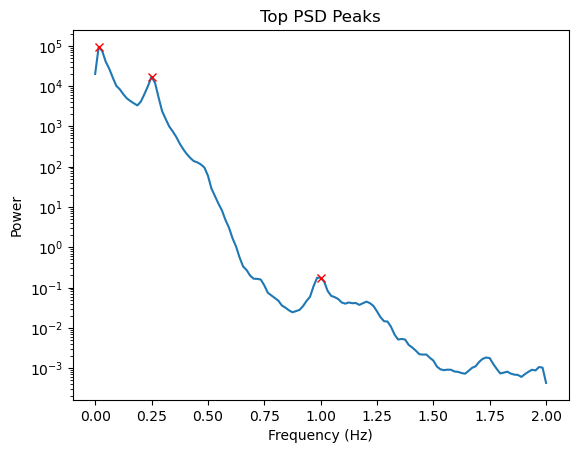



GR 0..1 : 0.22314355131420976
GR 1..2:  0.06062462181643484


FILE:  data\ironman\I7


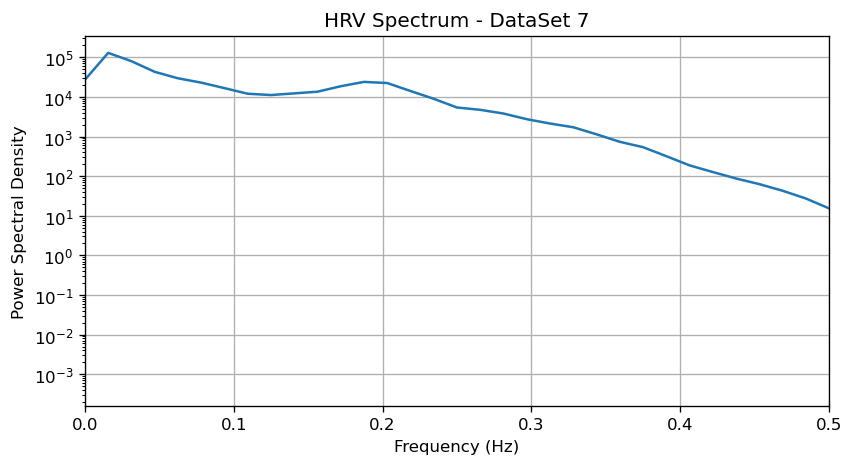

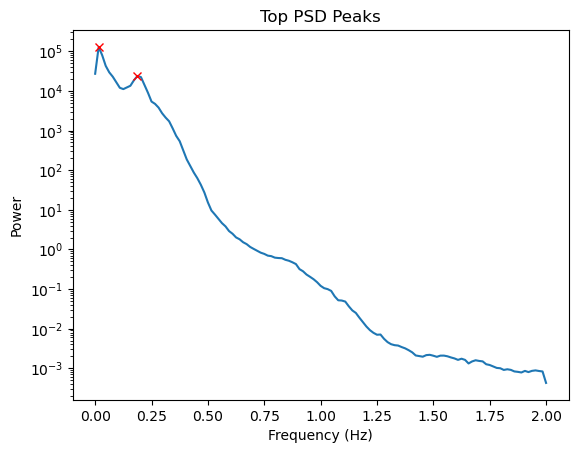



GR 0..1 : 0.08004270767353636


FILE:  data\ironman\I8


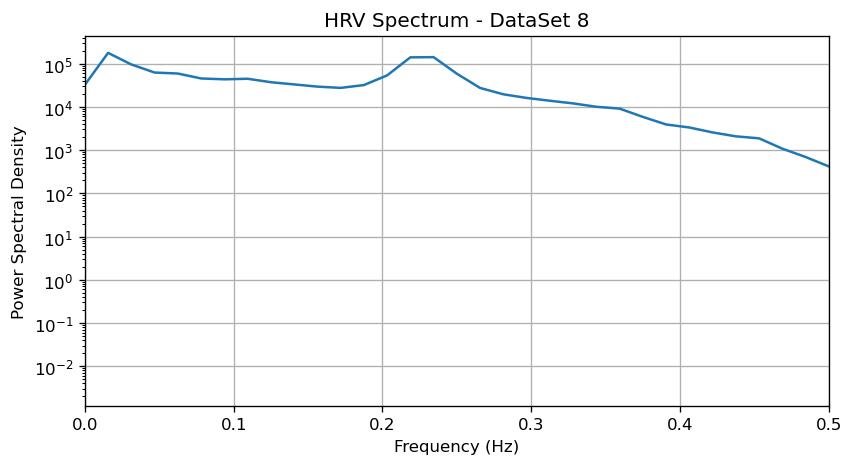

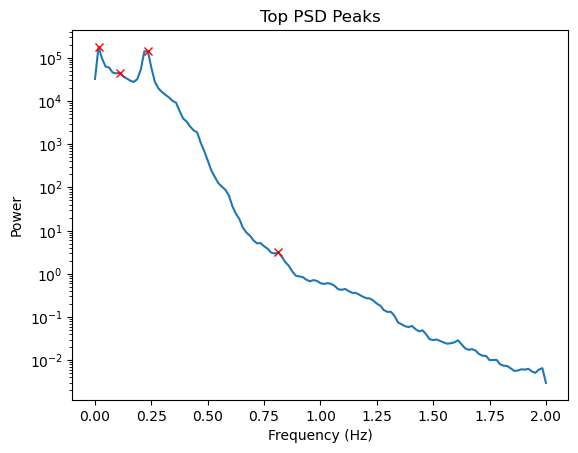



GR 0..1 : 0.12629372532429206
GR 1..2:  0.3829922522561057


FILE:  data\ironman\I9


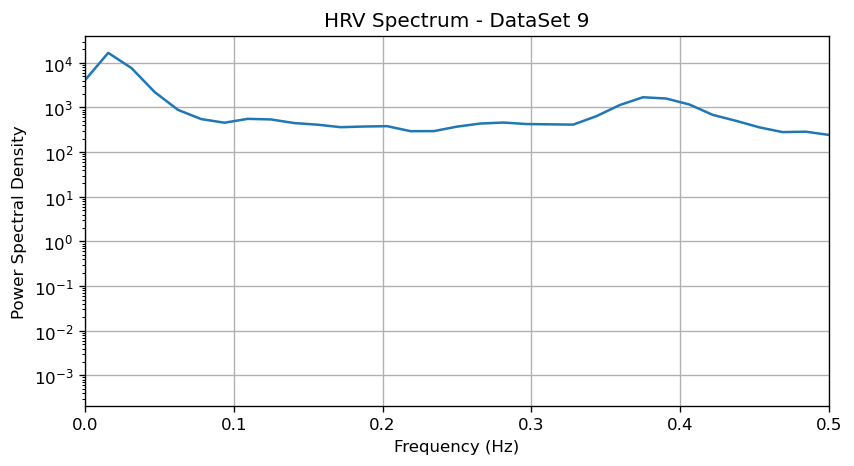

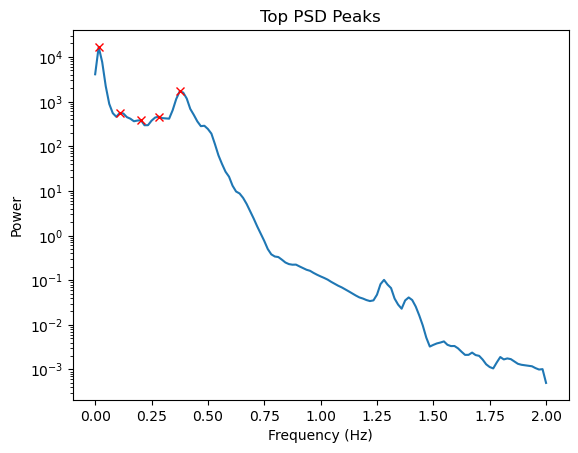



GR 0..1 : 0.5436154465889816
GR 1..2:  0.32850406697203605


FILE:  data\metron\M1


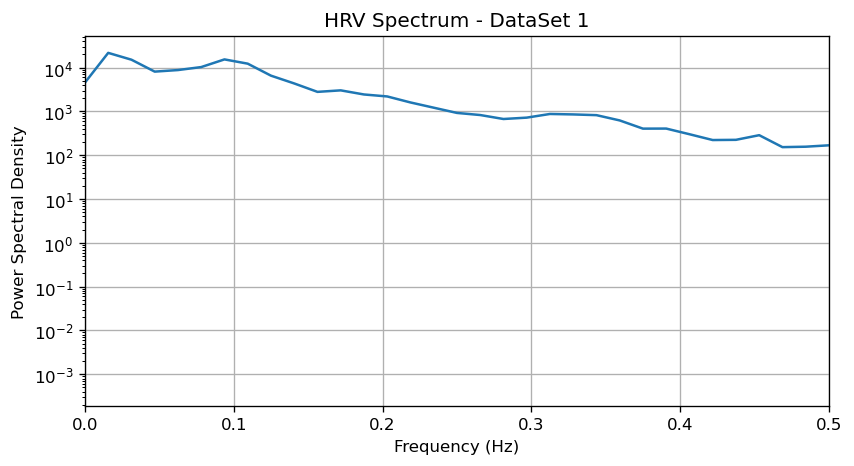

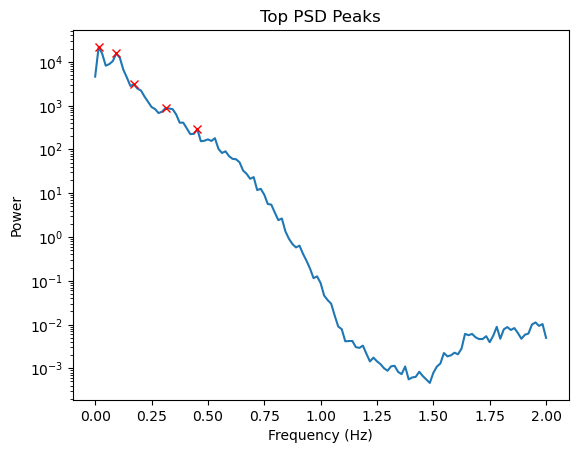



GR 0..1 : 0.5245244681241527
GR 1..2:  0.4382549309311553


FILE:  data\metron\M2


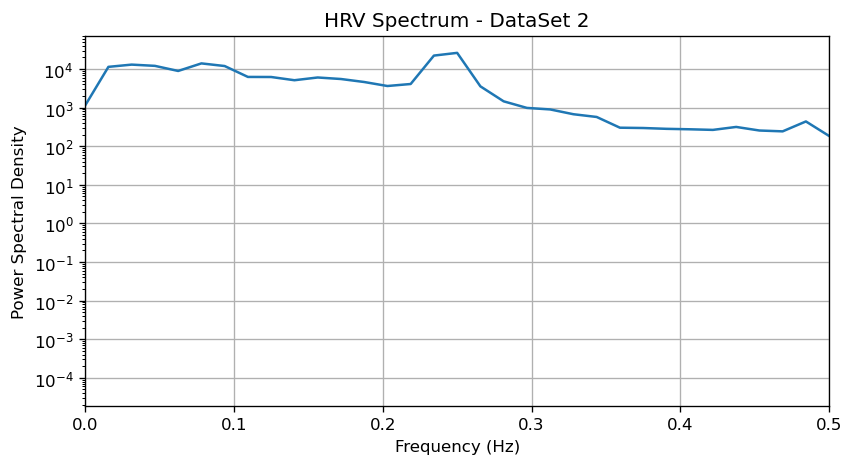

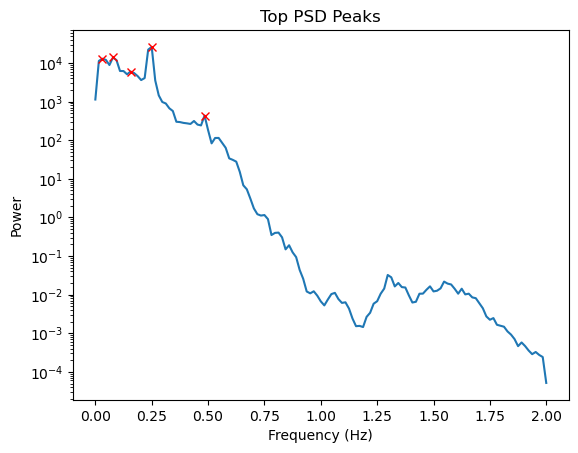



GR 0..1 : 0.2795848622191615
GR 1..2:  0.1823215567939546


FILE:  data\metron\M3


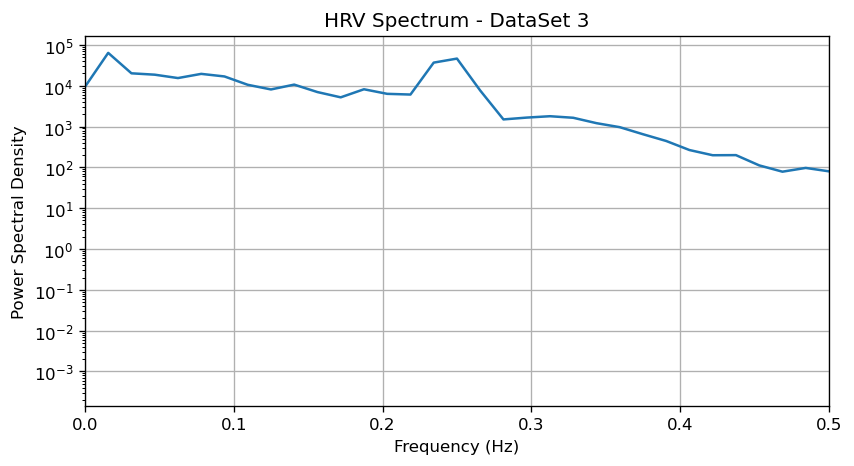

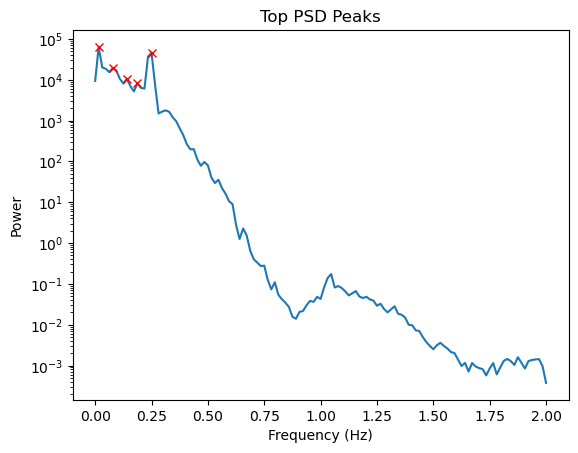



GR 0..1 : 0.5596157879354227
GR 1..2:  0.44183275227903923


FILE:  data\metron\M4


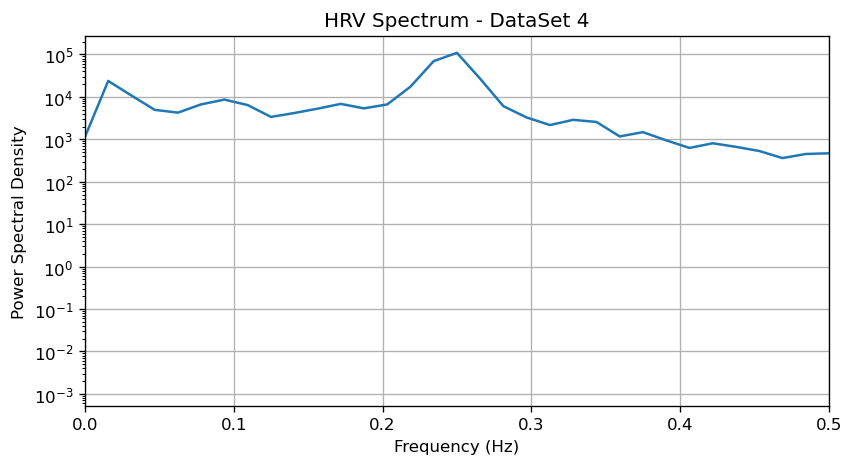

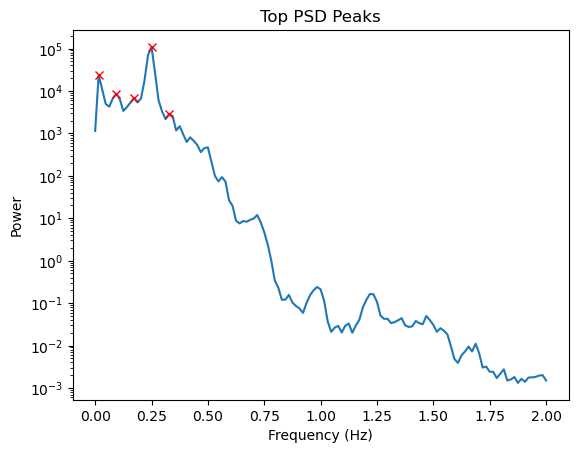



GR 0..1 : 0.4212134650763035
GR 1..2:  0.4353180712578455


FILE:  data\metron\M5


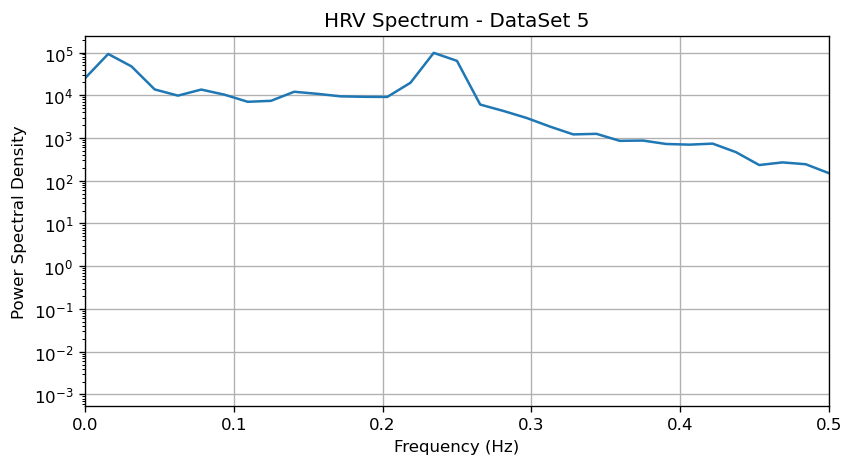

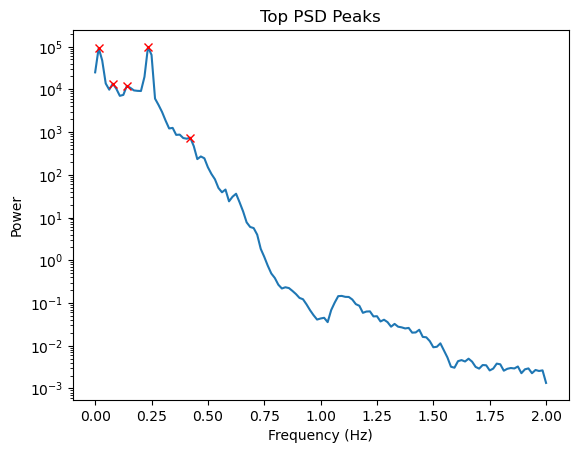



GR 0..1 : 0.28768207245178085
GR 1..2:  0.44183275227903923


FILE:  data\metron\M6


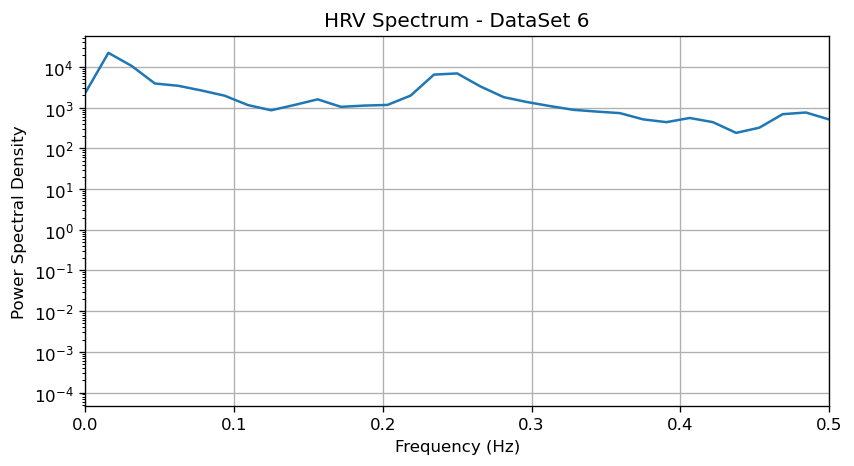

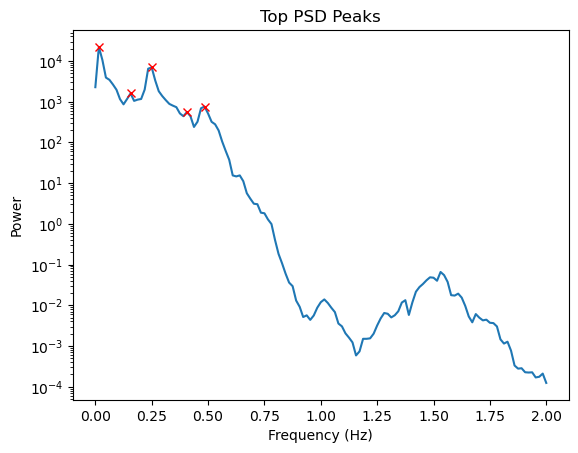



GR 0..1 : 0.6090640633494039
GR 1..2:  0.2795848622191615


FILE:  data\metron\M7


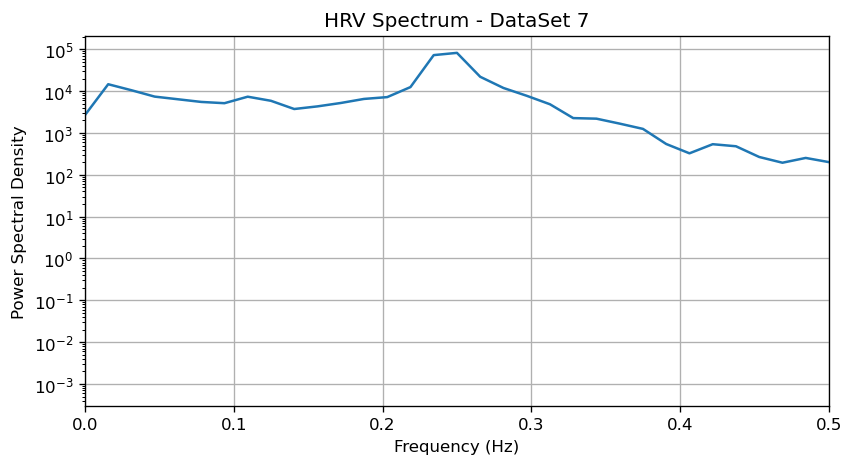

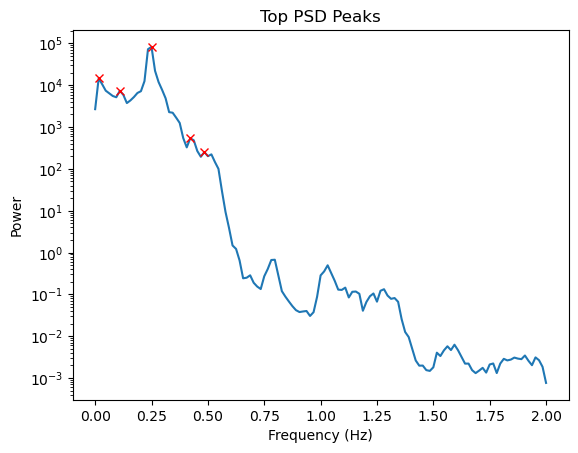



GR 0..1 : 0.626455806061273
GR 1..2:  0.23052365861183235


FILE:  data\metron\M8


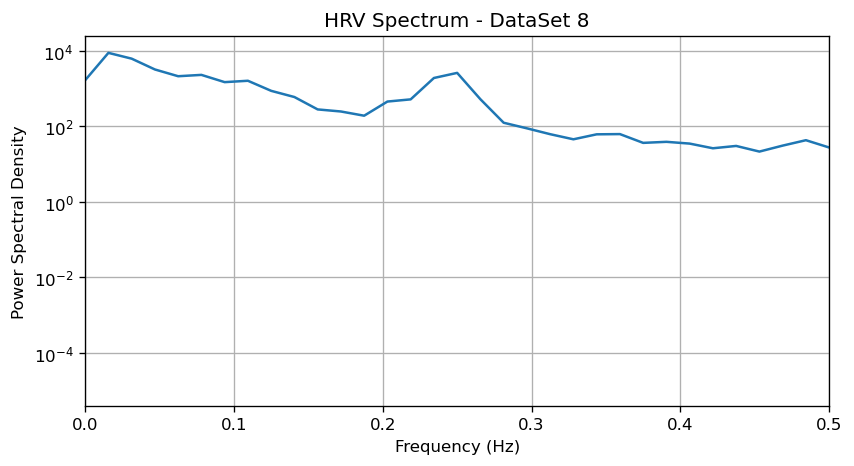

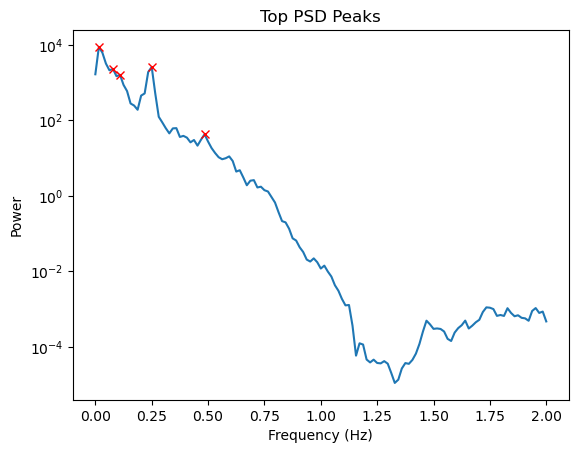



GR 0..1 : 0.20359895524123955
GR 1..2:  0.5389965007326869


FILE:  data\metron\M9


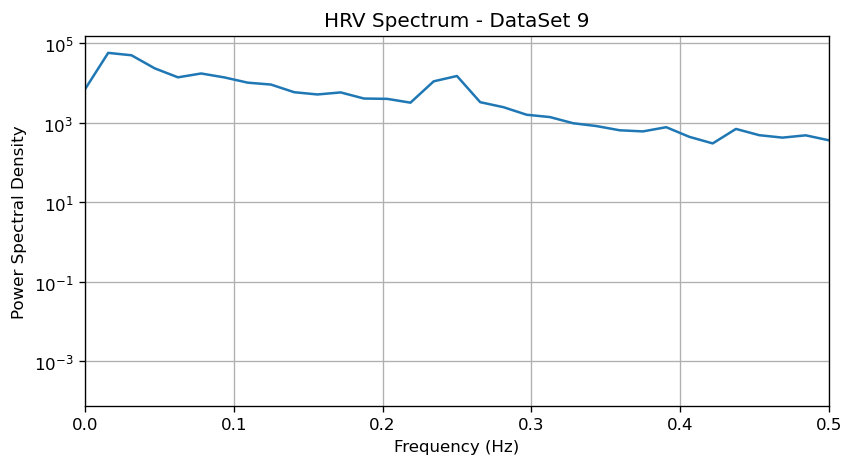

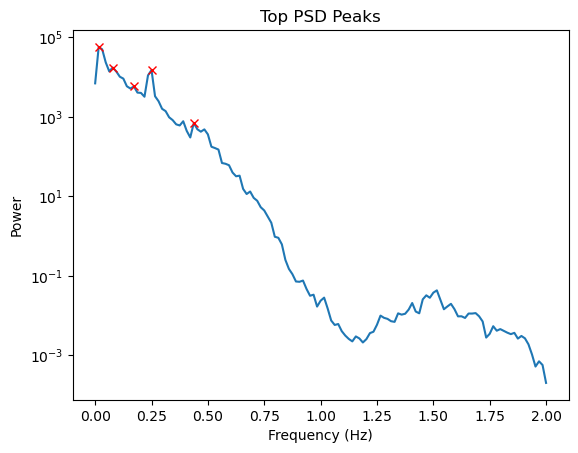



GR 0..1 : 0.33135713595444244
GR 1..2:  0.3746934494414107


FILE:  data\metron\M10


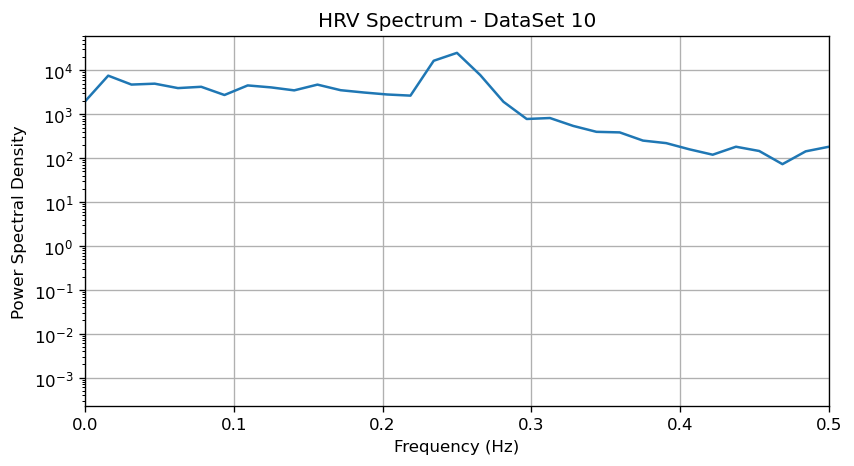

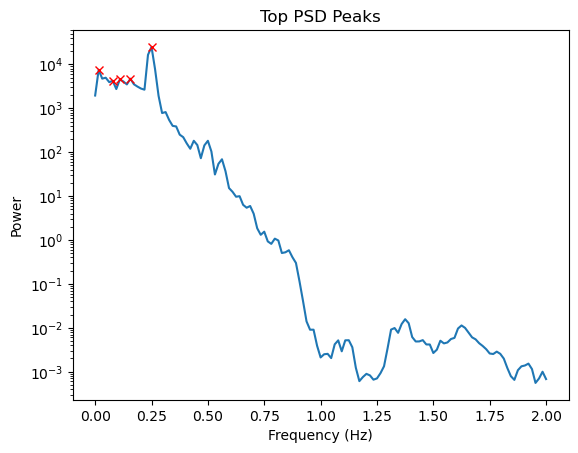



GR 0..1 : 0.5389965007326869
GR 1..2:  0.5306282510621704


FILE:  data\metron\M11


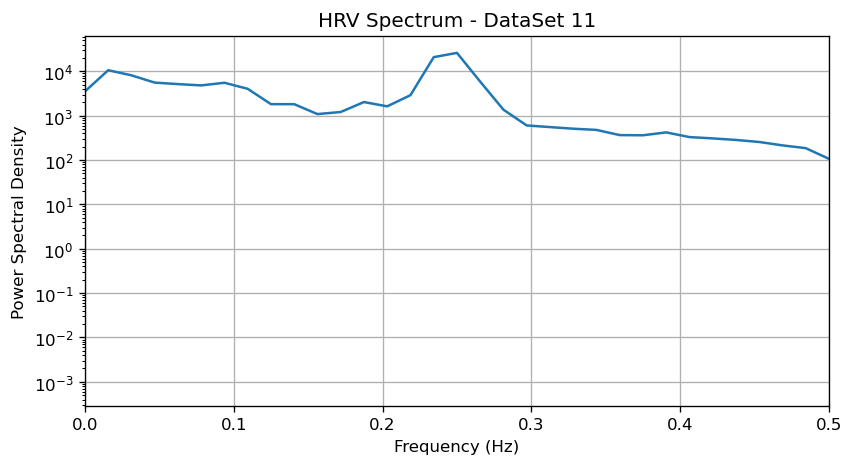

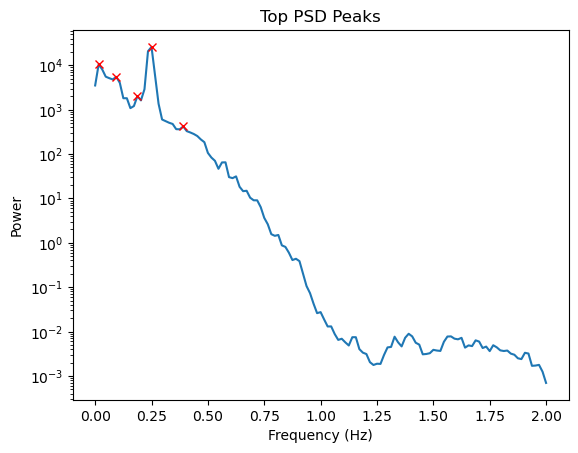



GR 0..1 : 0.3920420877760237
GR 1..2:  0.4054651081081644


FILE:  data\metron\M12


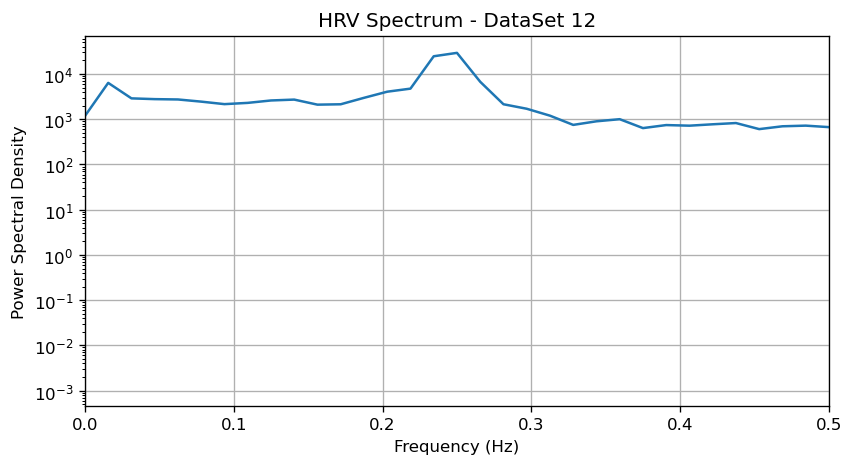

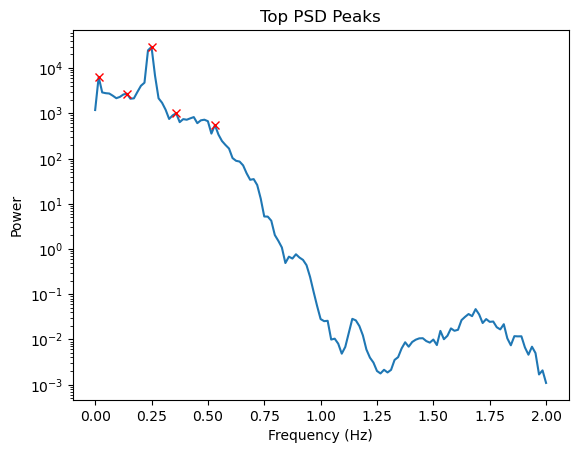



GR 0..1 : 0.5166907432183888
GR 1..2:  0.3302416868705768


FILE:  data\metron\M13


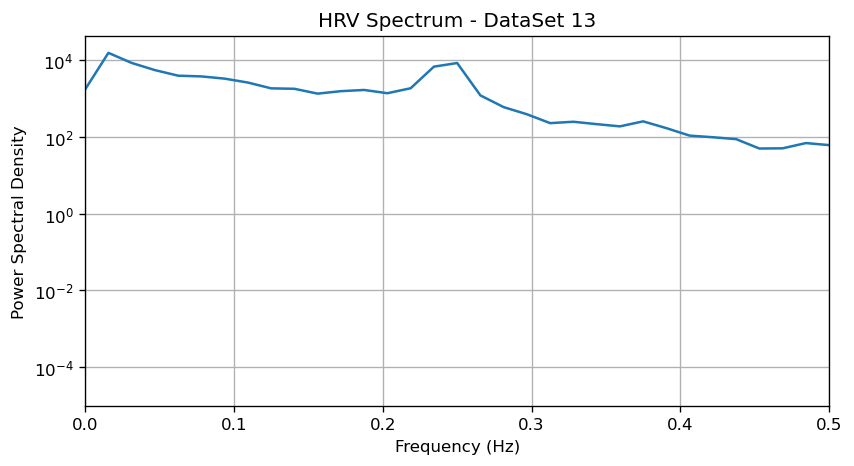

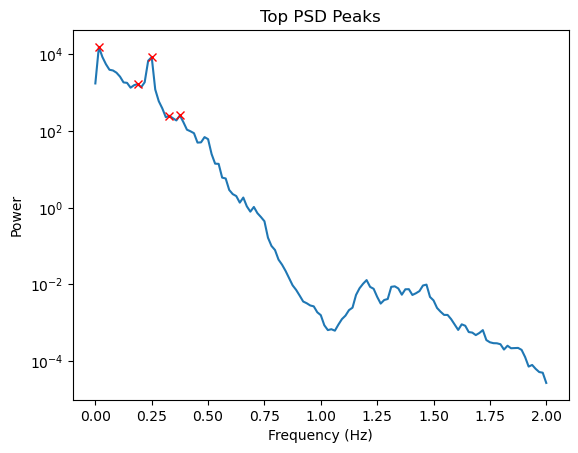



GR 0..1 : 0.6286086594223741
GR 1..2:  0.4054651081081644


FILE:  data\metron\M14


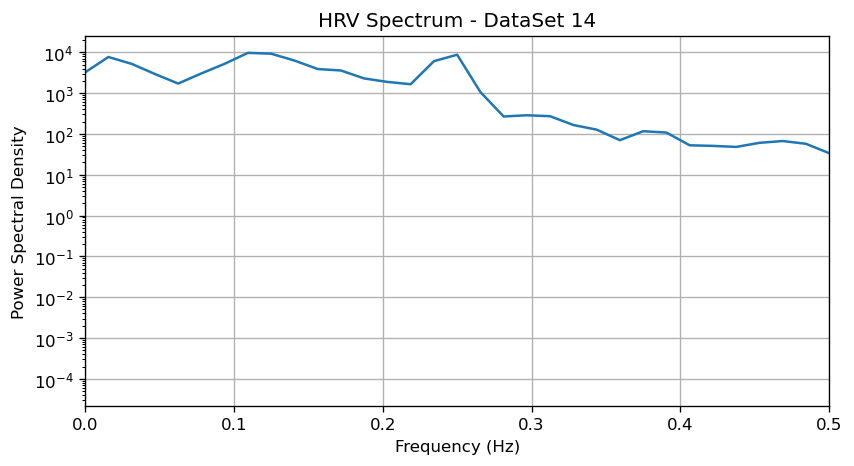

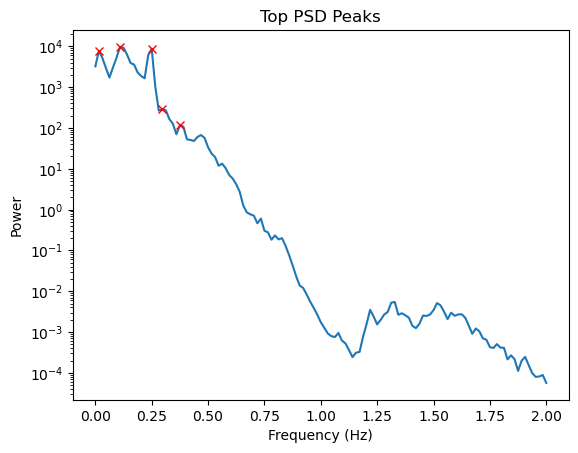



GR 0..1 : 0.5831462853456169
GR 1..2:  0.0408219945202552


FILE:  data\normal\N1


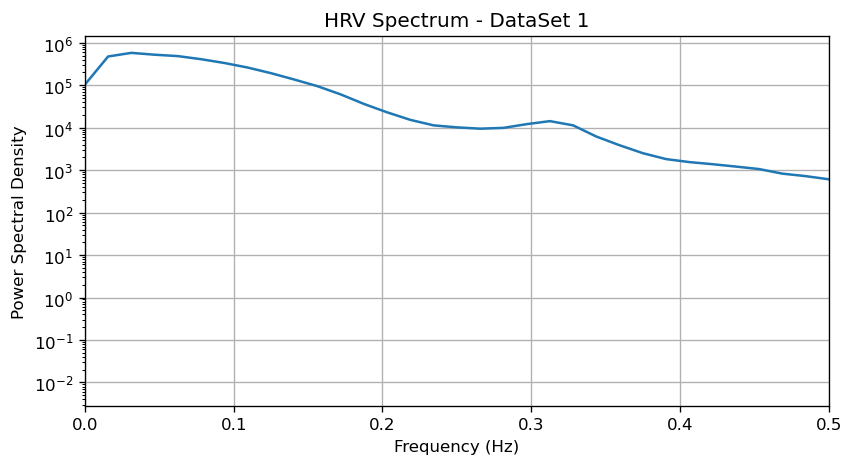

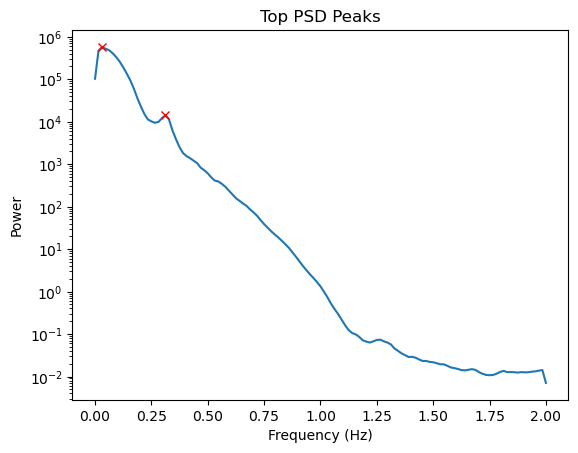



GR 0..1 : 0.09531017980432493


FILE:  data\normal\N2


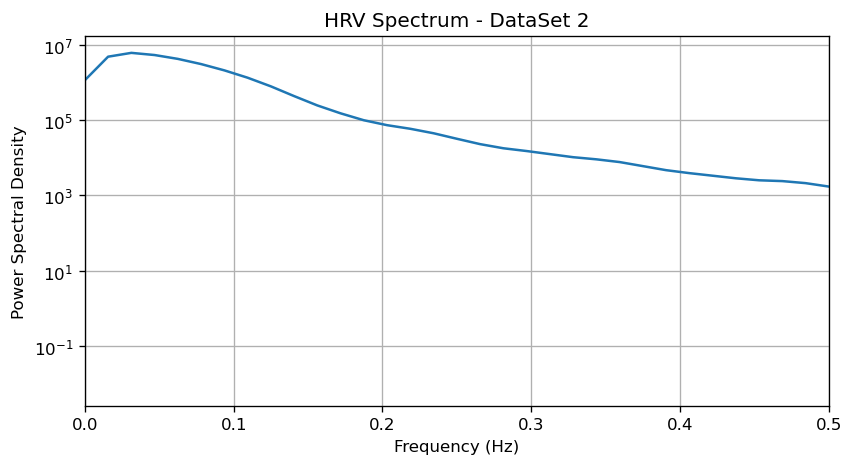

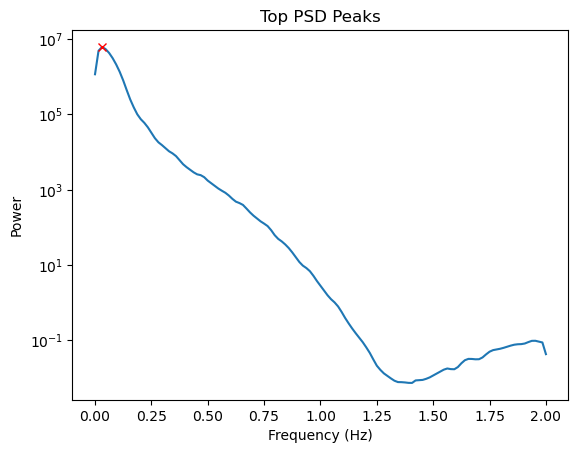



FILE:  data\normal\N3


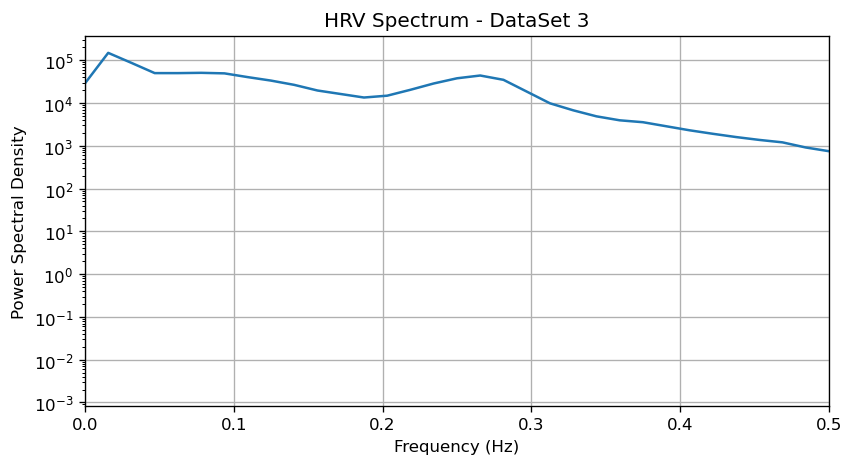

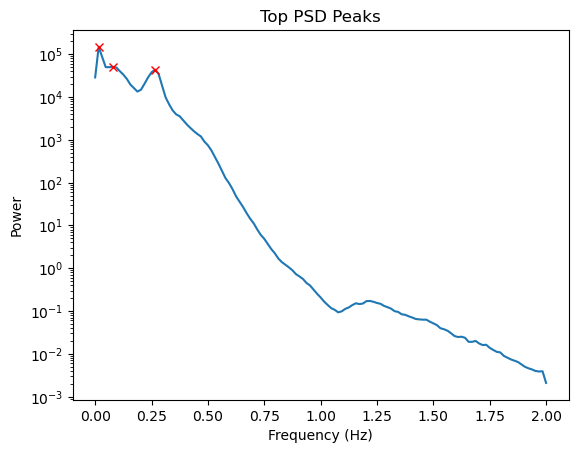



GR 0..1 : 0.25782910930209985
GR 1..2:  0.05715841383994862


FILE:  data\normal\N4


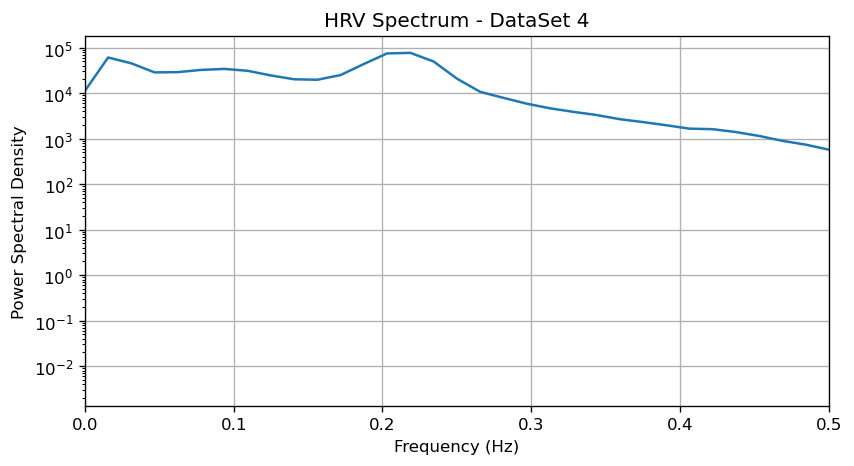

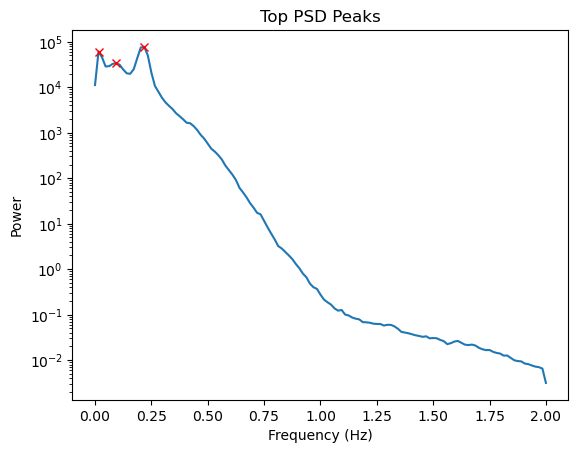



GR 0..1 : 0.15415067982725836
GR 1..2:  0.06899287148695142


FILE:  data\normal\N5


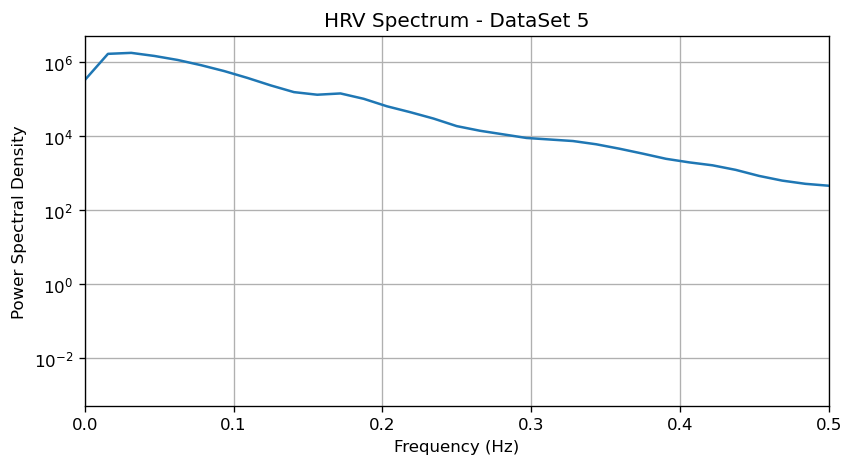

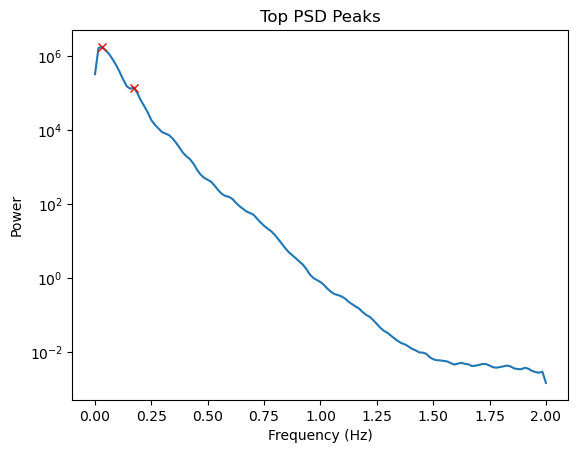



GR 0..1 : 0.16705408466316624


FILE:  data\normal\N6


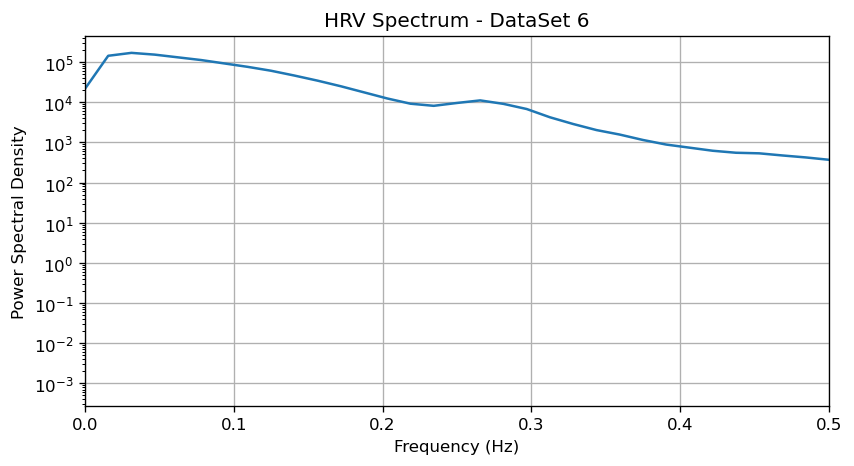

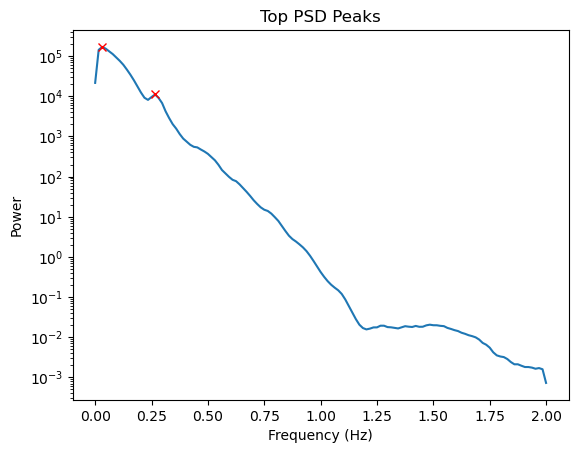



GR 0..1 : 0.1112256351102244


FILE:  data\normal\N7


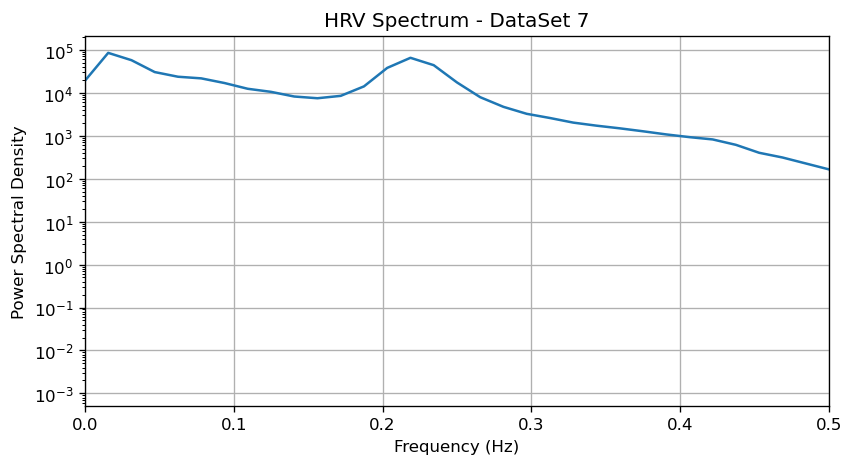

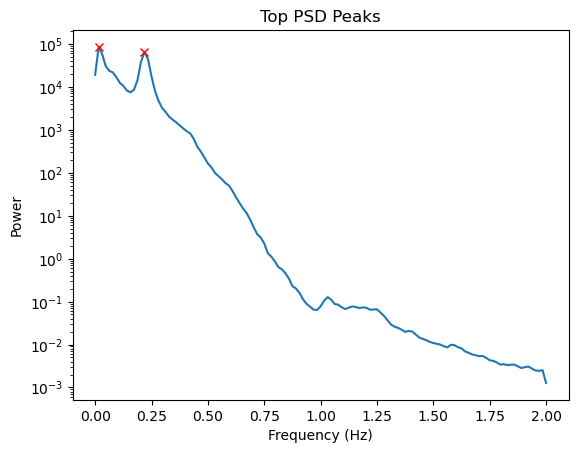



GR 0..1 : 0.06899287148695142


FILE:  data\normal\N8


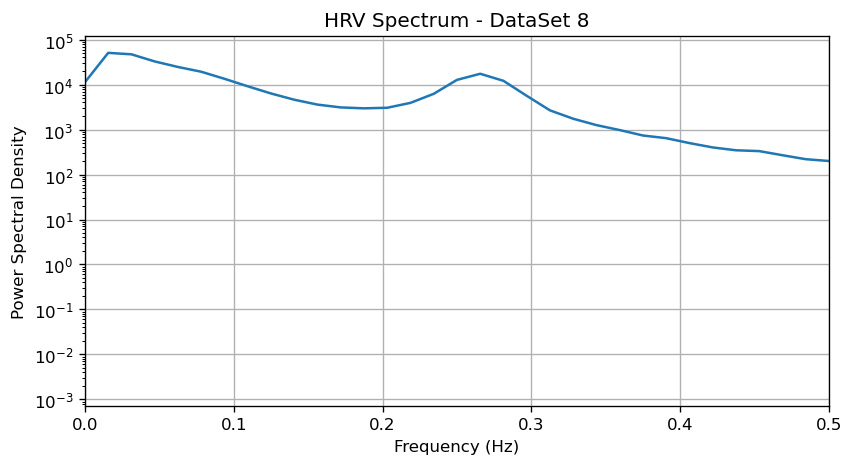

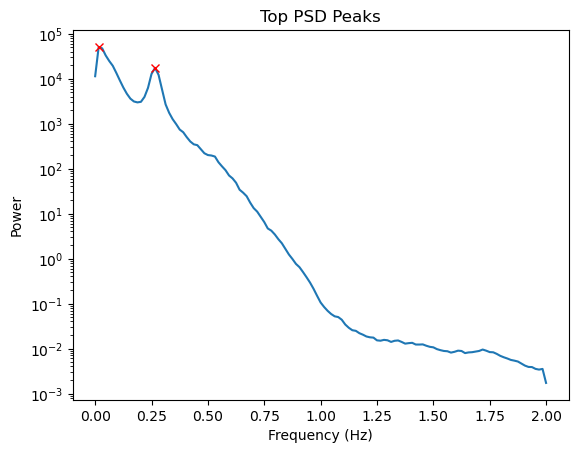



GR 0..1 : 0.05715841383994862


FILE:  data\normal\N9


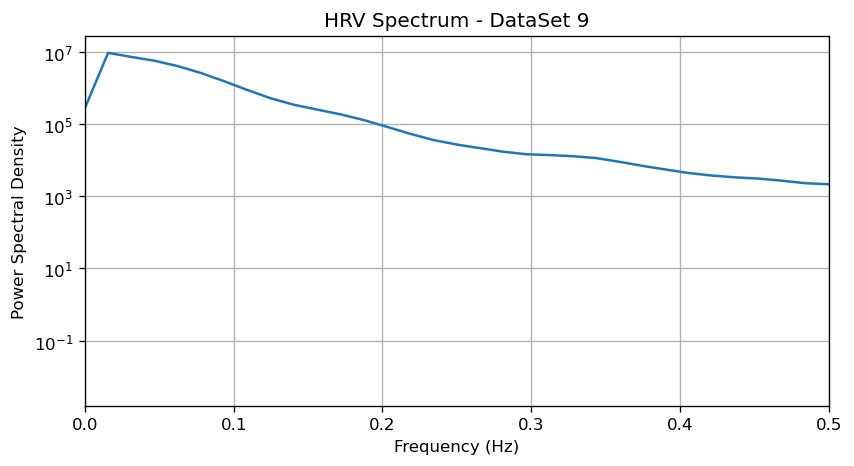

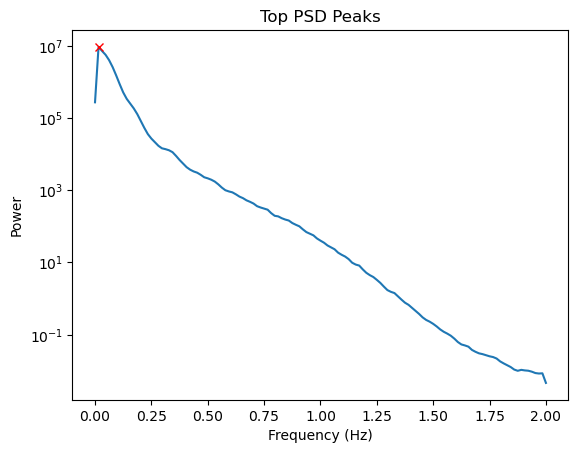



FILE:  data\normal\N10


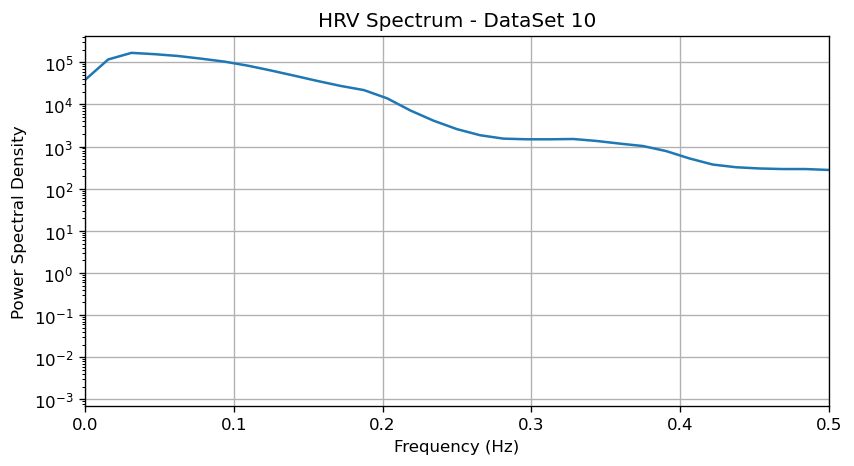

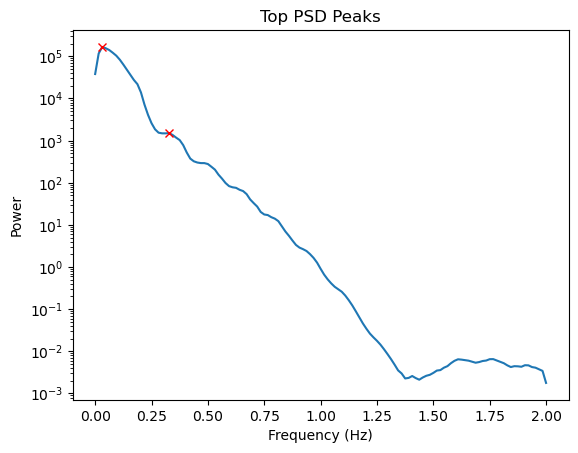



GR 0..1 : 0.09097177820572679


FILE:  data\normal\N11


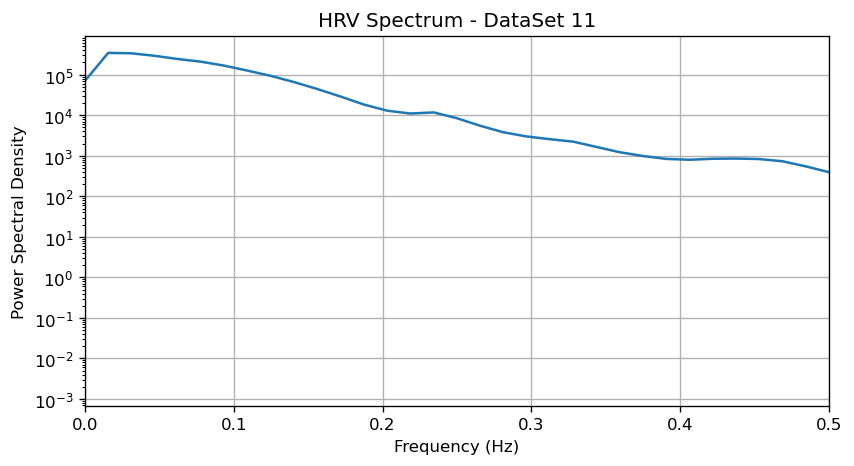

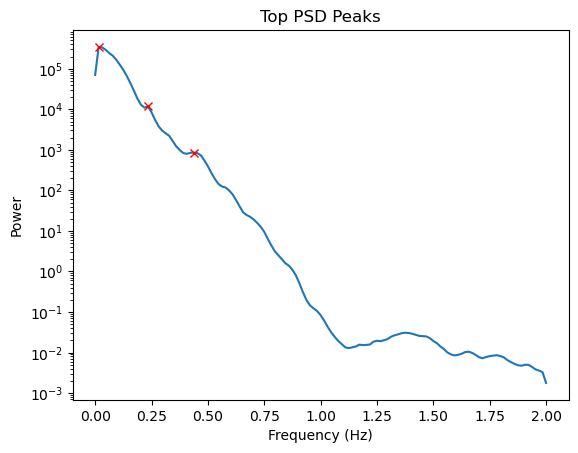



GR 0..1 : 0.4289956055183586
GR 1..2:  0.06453852113757116


FILE:  data\yoga\Y1.pre


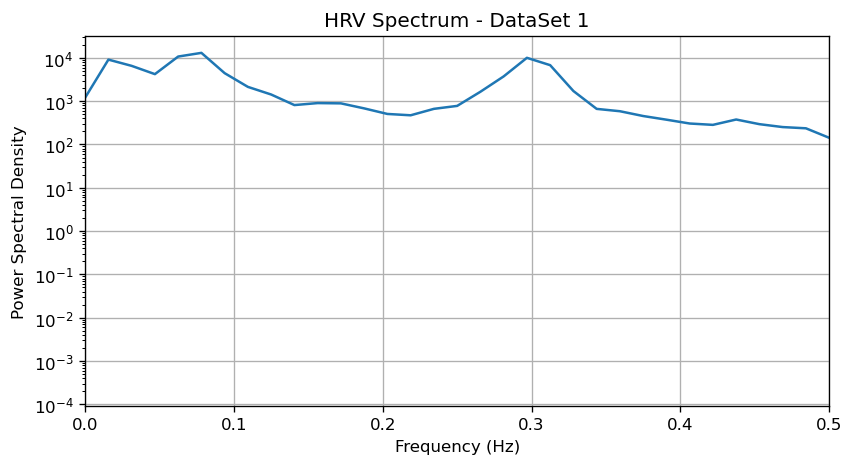

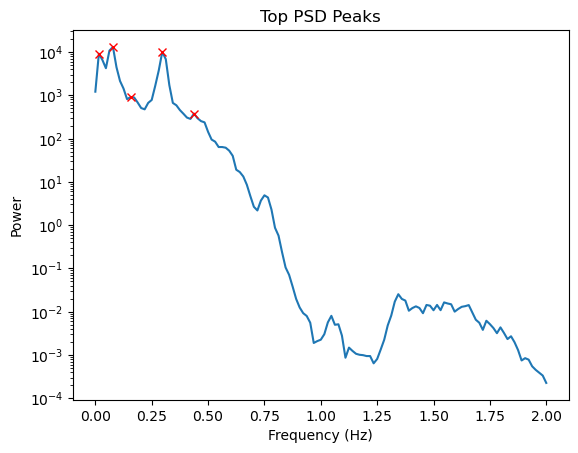



GR 0..1 : 0.3053816495511819
GR 1..2:  0.03509131981127019


FILE:  data\yoga\Y2.pre


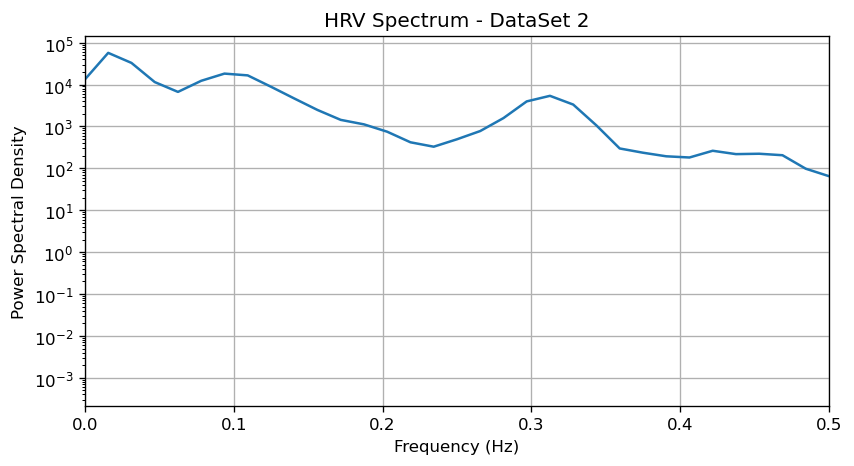

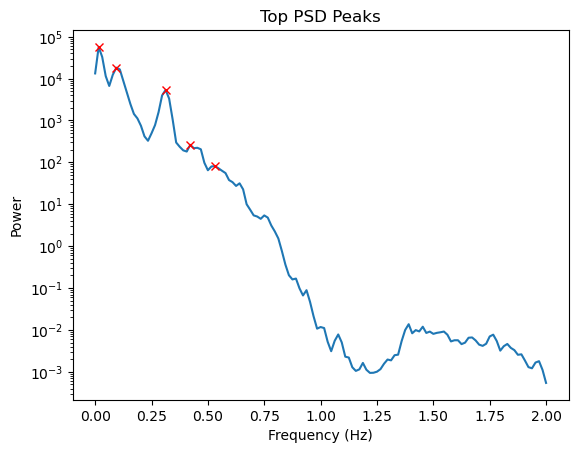



GR 0..1 : 0.5845133395571499
GR 1..2:  0.5543107357057295


FILE:  data\yoga\Y3.pre


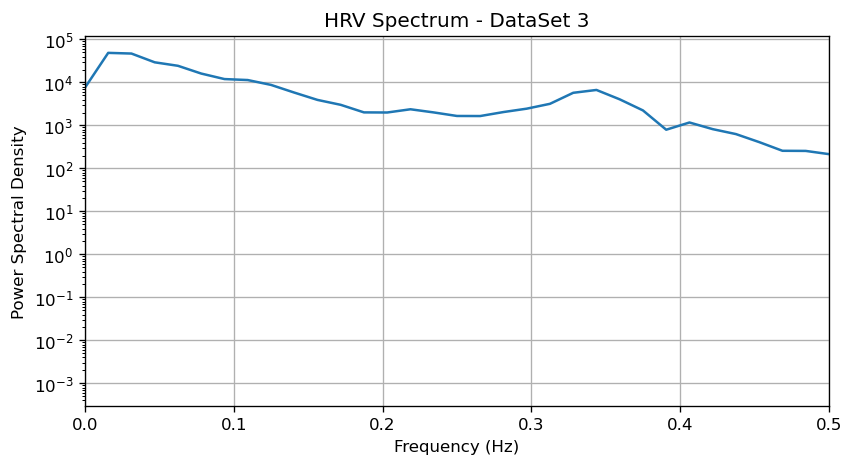

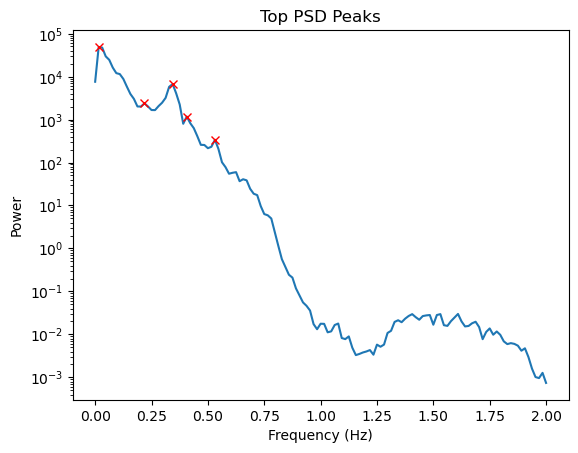



GR 0..1 : 0.5679840376059393
GR 1..2:  0.43078291609245434


FILE:  data\yoga\Y4.pre


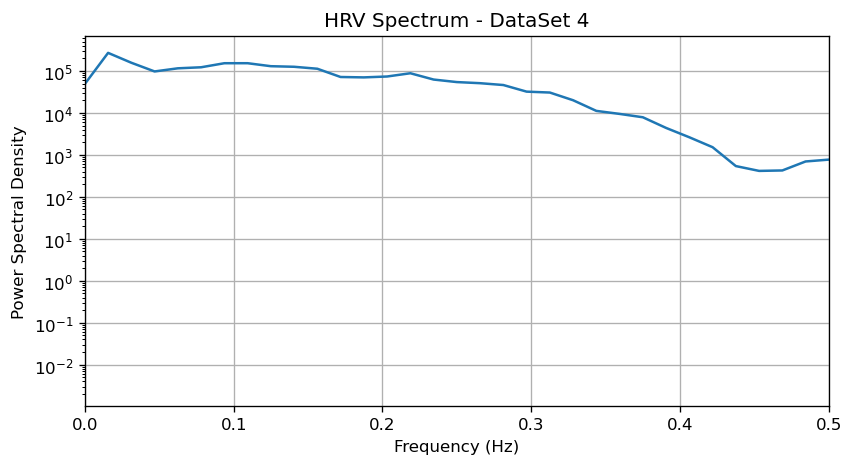

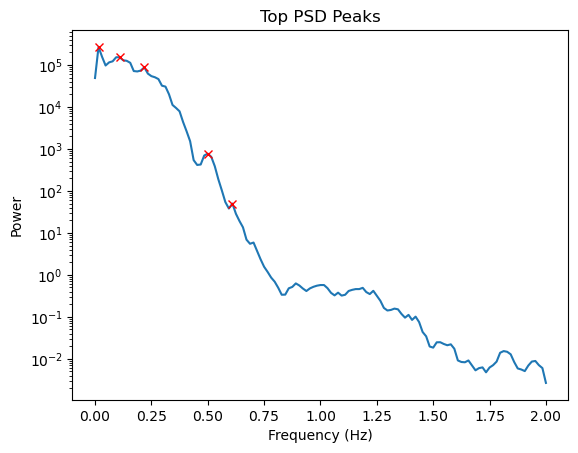



GR 0..1 : 0.5991182309116689
GR 1..2:  0.3629054936893685


FILE:  data\yoga\Y1.med


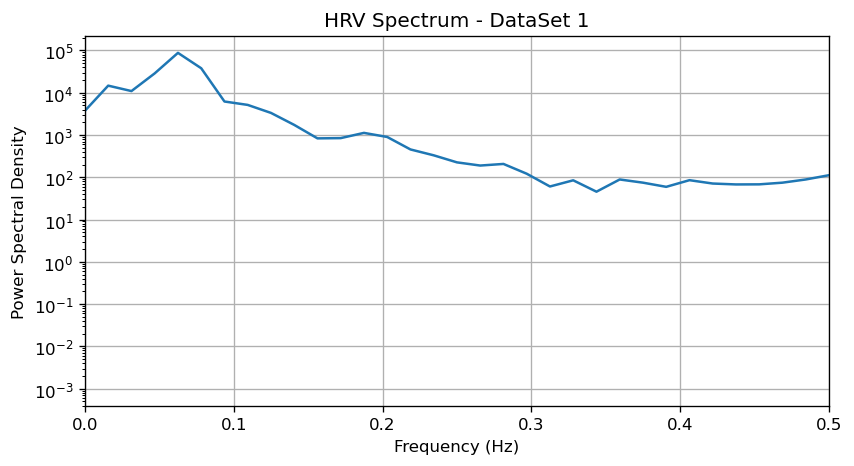

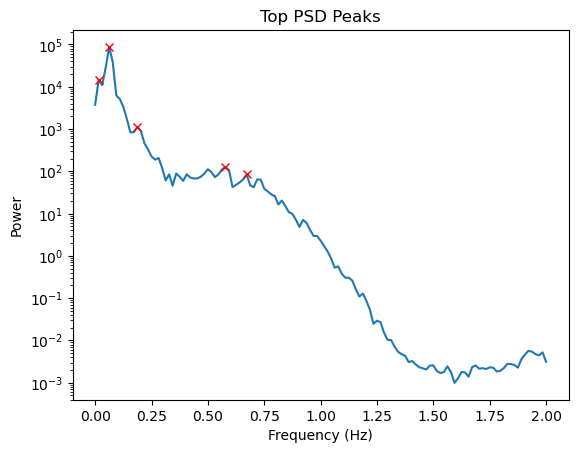



GR 0..1 : 0.6208265189803192
GR 1..2:  0.28090238546640217


FILE:  data\yoga\Y2.med


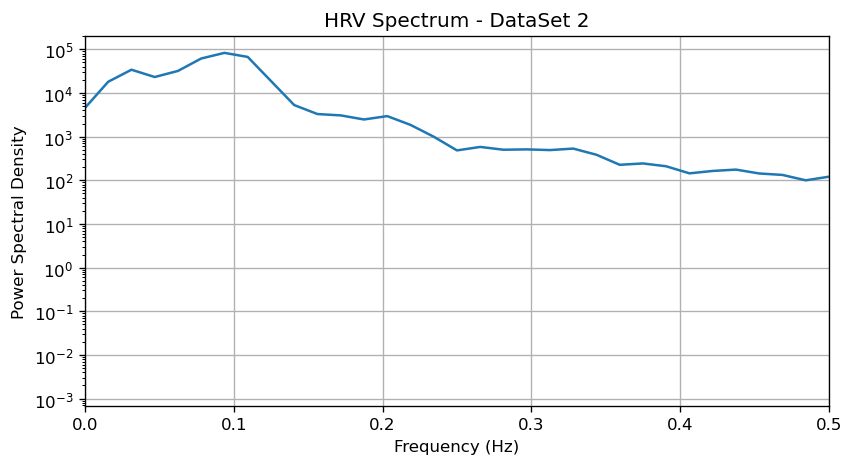

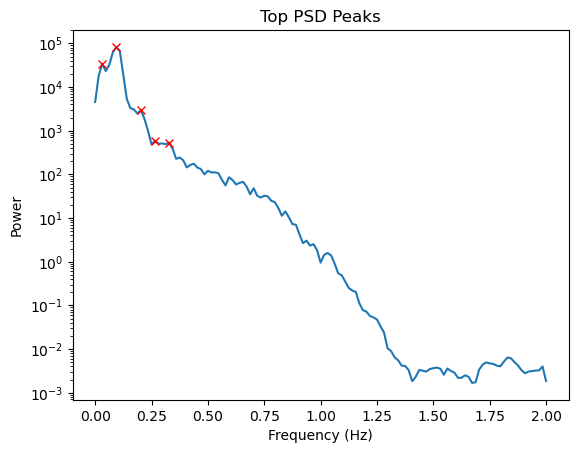



GR 0..1 : 0.5930637220029628
GR 1..2:  0.5679840376059393


FILE:  data\yoga\Y3.med


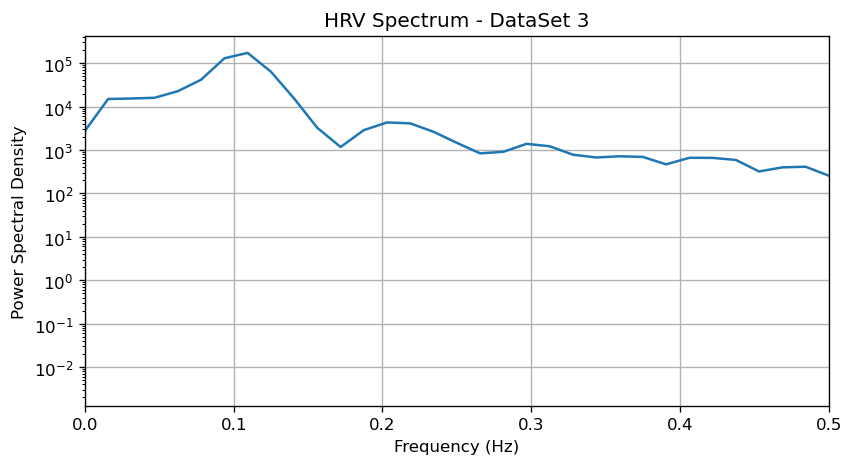

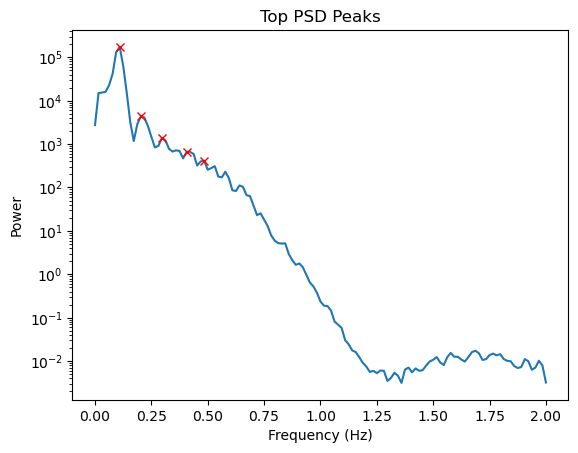



GR 0..1 : 0.6090640633494039
GR 1..2:  0.5485659517488377


FILE:  data\yoga\Y4.med


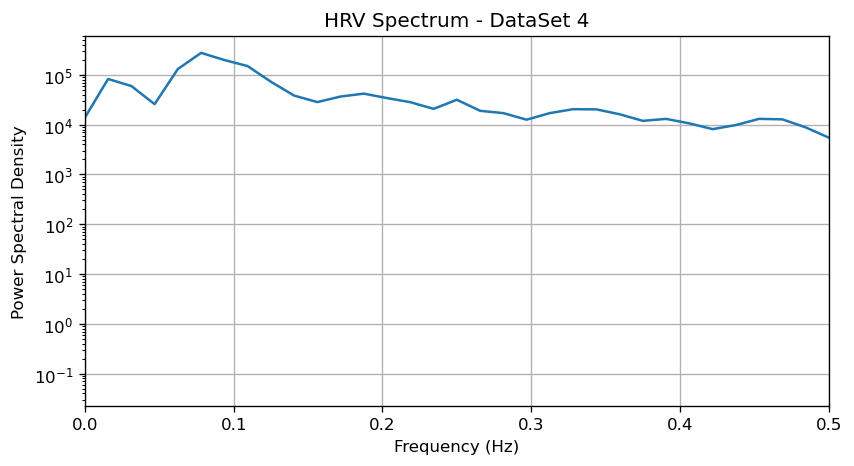

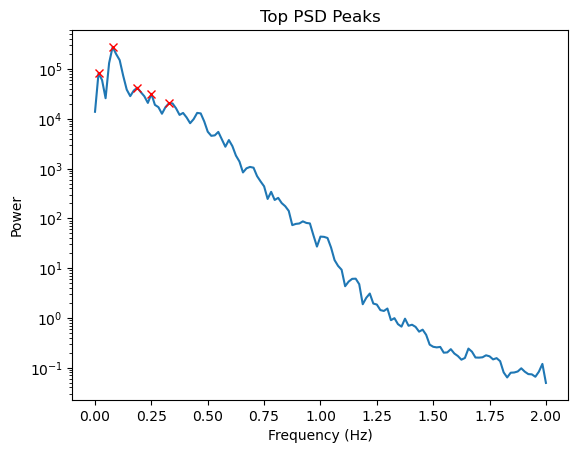



GR 0..1 : 0.5663954749208014
GR 1..2:  0.5596157879354227


In [193]:
"""Download and process all PhysioNet heart rate (HR) data sets for analysis."""
#EVERYTHING 
#PhysioNet HR data
#Exaggerated Heart Rate Oscillations During Two Meditation Techniques; Peng, Mietus, Liu, Khalsa, Douglas, Benson, Goldberger 		
import math
import numpy as np 
from scipy.signal import welch
from scipy import interpolate
from scipy.signal import find_peaks
import pandas as pd 
import matplotlib.pyplot as plt

#2 types of meditation and control groups 
set = {'chipre': {'prefix': 'chi/C', 'suffix': '.pre', 'count': 8},
       'chimed': {'prefix': 'chi/C', 'suffix': '.med', 'count': 8},
       'ironm': {'prefix': 'ironman/I', 'suffix': '', 'count': 9},
       'metron': {'prefix': 'metron/M', 'suffix': '', 'count': 14},
       'norm': {'prefix': 'normal/N', 'suffix': '', 'count': 11},
       'yogapre': {'prefix': 'yoga/Y', 'suffix': '.pre', 'count': 4},
       'yogamed': {'prefix': 'yoga/Y', 'suffix': '.med', 'count': 4}}
#next time do blob

#make csv for sorting and analyzing later
ofname = DATA_DIR / "specials.csv" 
with open(ofname,"w") as ofile:
    ofile.write('filename , GR 0..1 , GR 1..2\n')

for groupnm, grpdict in set.items():  
    for i in range(int(grpdict['count'])):
        j = i + 1 
        #sub-dir for this set 
        SUB_DIR = Path("data/" + grpdict['prefix'].split('/')[0])
        SUB_DIR.mkdir(exist_ok=True)
        med_file = grpdict['prefix'] + str(j) + grpdict['suffix']
        ds = get_lines(med_file)

        df_med = pd.read_csv(
            StringIO(ds), 
            sep='\\s+', 
            header=None,names=["time_s","HR_bpm"],
            dtype={"time_s": float, "HR_bpm": float})

        beat_times = df_med['time_s']  
        # Compute RR intervals (in seconds)
        rr_intervals_sec = np.diff(beat_times)
        # Convert to milliseconds
        rr_intervals_ms = rr_intervals_sec * 1000
        # Create cumulative time series from RR intervals
        rr_times = beat_times[1:]  # timestamps aligned with rr_intervals
        fs = 4.0  # desired interpolation rate in Hz (commonly 4 Hz for HRV)
    
        # Create interpolation function
        interp_func = interpolate.interp1d(rr_times, rr_intervals_ms, kind='cubic', fill_value = 'extrapolate')
        # Evenly spaced time grid
        t_even = np.arange(rr_times.iloc[0], rr_times.iloc[-1], 1/fs)
        rr_interp = interp_func(t_even)
    
        # apply FFT (or Welch) to get power spectral density
        f, Pxx = welch(rr_interp, fs=fs, nperseg=256)  
        #print ('len f',len(f))

        #Plot the power spectral density
        plt.figure(figsize=(8,4), dpi=120)
        plt.semilogy(f, Pxx)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('HRV Spectrum - DataSet ' + str(i+1))
        plt.xlim(0, 0.5)  # HRV bands are usually below 0.5 Hz
        plt.grid(True)
        plt.show()
        plt.close()
    
        # Find all peaks
        peaks, properties = find_peaks(Pxx, height=None, prominence=0.1) #0.001  
        # 'prominence' helps filter out noise; tune threshold based on data                 
        # Sort by peak height (descending)
        peak_heights = properties['prominences'] if 'prominences' in properties else Pxx[peaks]
        top_n = 5  # number of peaks to extract
        top_indices = peaks[np.argsort(peak_heights)[-top_n:]]  # top N peaks by height
    
        # Corresponding frequencies and PSD values
        top_freqs = f[top_indices]
        top_powers = Pxx[top_indices]
             
        #print("Top frequencies:", top_freqs)
        #print("Top powers:", top_powers)
        
        plt.semilogy(f, Pxx)
        plt.plot(top_freqs, top_powers, "rx")  # red x marks the top peaks
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power')
        plt.title('Top PSD Peaks')
        plt.show()
        plt.close()

        #special ratio 
        if len(top_freqs) > 1:
            num = top_freqs[0] + top_freqs[1]
            denom = max(top_freqs[0], top_freqs[1])
            special = math.log(num / denom)
            print("\n\nGR 0..1 :", special)
        if len(top_freqs) > 2:
            num = top_freqs[1] + top_freqs[2]
            denom = max(top_freqs[1], top_freqs[2])
            special = math.log(num / denom)
            print("GR 1..2: ", special)
        
        # add to csv for later analysis 
        with open(ofname,"a") as ofile:
            ofile.write(grpdict['prefix'] + str(j) + grpdict['suffix'] + ' , ' + str(special0) + ' , ' + str(special1) + '\n')

# close it out 
ofile.close()
    
